In [ ]:
#Input image of 28x28 from MNIST
#Convolution layer with 4 kernels of size 5x5 RelU activation and stride 1. Output and input should match
#Max pooling layer 2x2 with stride 2
# Convolution layer with 4 kernels of size 5x5x4, RelU and stride 1. Output and input should match.
#Max pooling layer of size 2x2
#Flattening layer with identity matrix as weight matrix
#MLP with 1 hidden layer with 49 nodes and 10 output nodes. RelU and softmax
#Use cross entropy loss to find error at softmax layer
#Bacporopogation vanilla SGD-learning rate 0.001, momentum learning_rate= 0.001 ,alpha 0.9, RMS Prop - learning_rate=0.001,rho=0.9 

In [10]:
#Conv layer functions

import math
import numpy as np
from PIL import Image

In [2]:
import torch 
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [92]:
from sklearn.manifold import TSNE

In [3]:
train_dataset=torchvision.datasets.MNIST('D:/Classes/Deep Learning',train=True,download=False)

In [4]:
key_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}

for i in range(len(train_dataset)):
    label = train_dataset[i][1]
    key_dict[label].append(i)
  

In [6]:
train_data = []
for i in range(len(key_dict.keys())):
    indexes = key_dict[i][0:100]
    for j in range(len(indexes)):
        train_data.append([train_dataset[j][0],train_dataset[j][1]])

    

In [7]:
test_dataset = torchvision.datasets.MNIST('D:/Classes/Deep Learning',train=False,download=True)

In [8]:
key_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
for i in range(len(test_dataset)):
    label = test_dataset[i][1]
    key_dict[label].append(i)
  

In [9]:
test_data = []
for i in range(len(key_dict.keys())):
    indexes = key_dict[i][0:10]
    for j in range(len(indexes)):
        test_data.append([test_dataset[j][0],test_dataset[j][1]])

7

In [11]:
#ReLU function
def RelU(x,derivative = False):
  if derivative:
    for i in range(x.shape[0]):
      for j in range(x.shape[1]):
        if RelU(x[i,j]) == 0:
          x[i,j] = 0
        else:
          x[i,j] = 1
    return x
  else:
    return np.maximum(0,x)

In [12]:
#Softmax
def softmax_fn(x,derivative = False):
  exp = np.exp(x)
  x = exp/sum(exp)
  if derivative:
    return x*(1-x)
  else:
    return x

In [13]:
def BCE(p,q,derivative = False):
  if derivative:
    p = list(p)
    q = list(q)
    value = []
    for i in range(len(p)):
      value.append(np.divide(q[i]-p[i],np.multiply(q[i],1-q[i])))
    return np.array(value)
  else:
      value = []
      p = list(p)
      q = list(q)
      for i in range(len(p)):
        value.append((-p[i]*np.log(q[i]) - (1-p[i])*np.log(1-q[i])))
      return np.array(value)

In [14]:
#flip the image
def flip_image(image):
    image_copy = image.copy()
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image_copy[i][j] = image[image.shape[0]-i-1,image.shape[1]-j-1]
    return image_copy

In [15]:
def padding_image(image,padding):
    r = padding
    s = padding
    
    W = image.shape[0]
    H = image.shape[1]
    C = image.shape[2]
    
    padded_array = np.zeros((W+2*r,H+2*s,C))
    padded_array[r:W+r,s:H+s] = image
    return padded_array

In [16]:
def conv1(image,kernel,stride,padding,act_function=RelU,act_func=True):
    if len(image.shape) < 3:
      image = np.reshape(image,(image.shape[0],image.shape[1],1))
    if len(kernel.shape)<3:
      kernel=np.reshape(kernel,(kernel.shape[0],kernel.shape[1],1))

    kernel = flip_image(kernel)
    padded_image = padding_image(image,padding)
    
    H = padded_image.shape[0]
    W = padded_image.shape[1]
    C = padded_image.shape[2]
    
    
    k_h = kernel.shape[0]
    k_w = kernel.shape[1]
    
    r = k_h//2
    s = k_w//2
    
    conv_h = (int((H-k_h)/stride) + 1)
    conv_w = (int((W-k_w)/stride) + 1)

    conv_image = np.zeros((conv_h,conv_w))
    res = list()
    for i in range(0, H-k_h+1, stride):
      row = list()
      for j in range(0,W-k_w+1,stride):
        row.append(np.sum(padded_image[i:i+k_h, j:j+k_w, :]*kernel))
      res.append(row)
      
	    
    conv_image = np.array([np.array(r) for r in res])		
    if act_func:
      return act_function(conv_image/np.sum(conv_image))
    else:
      return conv_image

In [18]:
#Max Pooling
def max_pool(image,stride,pool_size):
    H = image.shape[0]
    W = image.shape[1]
    pool_h = ((H-pool_size)//stride) + 1
    pool_w = ((W-pool_size)//stride) + 1 
    pooled_array = np.zeros((pool_h,pool_w))
    i1 = 0
    for i in range(0,H-pool_size+1,stride):
        j1 = 0
        for j in range(0,W-pool_size+1,stride):
            pooled_array[i1,j1] = np.max(image[i:i+pool_size,j:j+pool_size])
            j1+=1
        i1+=1
    return pooled_array
        

In [19]:
def conv_layer(image,kernels,stride,padding,act_function):
    
    kernel_depth = len(kernels)
    conv_h = (int((image.shape[0]-kernels[0].shape[0] + 2*padding)/stride) + 1)
    conv_w = (int((image.shape[1]-kernels[0].shape[1] + 2*padding)/stride) + 1)
    
    conv_output = np.zeros((conv_h,conv_w,kernel_depth))
    
    for i in range(kernel_depth):
#         kernel = np.random.randint(2,size = kernel_size)
        conv_output[:,:,i] = conv1(image,kernels[i],stride,padding,act_function)
    return conv_output
    

In [20]:
def get_kernels(number,size):
    kernels = []
    W = size[0]
    H = size[1]
    C = size[2]
    for i in range(number):
        kernel = np.random.rand(W,H,C)
        
        kernels.append(kernel)
    return kernels

In [21]:
def pooling_layer(act_map,pool_fn,stride,pool_size):
    H = act_map.shape[0]
    W = act_map.shape[1]
    C = act_map.shape[2]
    pool_h = ((H-pool_size)//stride) + 1
    pool_w = ((W-pool_size)//stride) + 1 
    
    pool_output = np.zeros((pool_h,pool_w,C))
    
    for i in range(C):
        pool_output[:,:,i] = pool_fn(act_map[:,:,i],stride,pool_size)
    return pool_output

In [22]:
def flattening_layer_identity(act_maps):
    H = act_maps.shape[0]
    W = act_maps.shape[1]
    C = act_maps.shape[2]
    
    feature_size = act_maps.shape[0]*act_maps.shape[1]*act_maps.shape[2]
    flattened_input = np.zeros(feature_size)
    ind = 0
    for i in range(C):
        for j in range(W):
            for k in range(H):
                flattened_input[ind] = act_maps[k,j,i]
                ind+=1
    return flattened_input

In [23]:
def flattening_layer(act_maps,size):
    H = act_maps.shape[0]
    W = act_maps.shape[1]
    C = act_maps.shape[2]
    

    feature_size = act_maps.shape[0]*act_maps.shape[1]*act_maps.shape[2]
    flatten_array = np.identity(size,feature_size)
    flattened_input = np.zeros(feature_size)
    ind = 0
    for i in range(C):
        for j in range(W):
            for k in range(H):
                flattened_input[ind] = act_maps[k,j,i]
                ind+=1
    return np.matmul(flatten_array,flattened_input.reshape((feature_size,1)))

In [25]:
def initialize_weights(input_vector_size,hidden_layers,hidden_layer_size,output_size):
  weights = []
  biases = []
  seed = np.random.randint(0,50)
  for i in range(hidden_layers):
    if i == 0:
        np.random.seed(seed)
        weight = np.random.rand(input_vector_size,hidden_layer_size[i])
        bias = np.random.rand(hidden_layer_size[i],1)
        weights.append(weight)
        biases.append(bias)
    elif i > 0:
      np.random.seed(seed)
      weight = np.random.rand(hidden_layer_size[i-1],hidden_layer_size[i])
      bias = np.random.rand(hidden_layer_size[i],1)
      weights.append(weight)
      biases.append(bias)
  np.random.seed(seed)
  weight = np.random.rand(hidden_layer_size[len(hidden_layer_size)-1],output_size)
  bias = np.random.rand(output_size,1)
  weights.append(weight)
  biases.append(bias)
  return weights,biases

In [192]:
class SGD():
    def __init__(self,learning_rate):
        self.learning_rate = learning_rate
       
    def sgd(self,weights,errors):
        weights -= self.learning_rate*errors
        return weights

class Momentum():
    def __init__(self,alpha,learning_rate):
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.change = 0
    def momentum(self,weights,errors):
        new_change = self.alpha*self.change + self.learning_rate*errors
        weights -= new_change
        self.change = new_change
        return weights
    
class RMSProp():
    def __init__(self,learning_rate,rho):
        self.learning_rate = learning_rate
        self.rho = rho
        self.gr = 0
    def rmsprop(self,weights,errors):
        new_gr = self.rho*self.gr + (1-self.rho)*(errors)
        weights -= np.divide(self.learning_rate*np.sqrt(errors),np.sqrt(new_gr+1e-08))
        self.gr = new_gr
        return weights
        
        

In [191]:
class ConvNet():
  def __init__(self,input_vector_size,hidden_layers,hidden_layer_size,output_size):
    self.hidden_layers = hidden_layers
    self.weights,self.biases = initialize_weights(input_vector_size,hidden_layers,hidden_layer_size,output_size)  
    self.kernel1 = get_kernels(4,(5,5,1))
    self.kernel2 = get_kernels(4,(5,5,4))
  
  def MLP(self,X,act_function):
    inputs = []
    inputs.append(np.reshape(X,(X.shape[0],1)))
    for i in range(self.hidden_layers+1):
      net_in = np.matmul(np.transpose(self.weights[i]),inputs[i]) + self.biases[i]
      net_out = act_function(net_in)
      inputs.append(net_out)
    inputs[-1] = softmax_fn(inputs[-1])
    return inputs
  
  def feedforward(self,image):
    conv_output1 = conv_layer(image,kernels=self.kernel1,stride=1,padding=2,act_function=RelU)
    print("Conv_output1 shape: ",conv_output1.shape)
    pool_output1 = pooling_layer(conv_output1,max_pool,stride=2,pool_size=2)
    print("\npool_output1 shape: ",pool_output1.shape)
    conv_output2 = conv_layer(pool_output1,kernels=self.kernel2,stride=1,padding=2,act_function=RelU)
    print("\nConv_output2 shape: ",conv_output2.shape)
    pool_output2 = pooling_layer(conv_output2,max_pool,stride=2,pool_size=2)
    print("\npool_output2 shape: ",pool_output2.shape)
    flattened_output = flattening_layer_identity(pool_output2)
    print("\nflattened_output shape: ",flattened_output.shape)
    mlp_output = self.MLP(flattened_output,act_function=RelU)
    print("\nHidden layer shape: ",mlp_output[1].shape)
    print("\nMlp Output shape", mlp_output[-1].shape)
    return mlp_output,pool_output2,conv_output2,pool_output1,conv_output1
  
  def mlp_backpropogate(self,inputs,y,weights,biases):
    m_o = np.matmul(np.transpose(weights[1]),inputs[1]) + biases[1] #input to output layer before activation (10,1)
    m_h = np.matmul(np.transpose(weights[0]),inputs[0]) + biases[0] #input to hidden layer before activation (49,1)
    delta_output_b = BCE(y,inputs[2],derivative=True)*softmax_fn(m_o,derivative=True) #error of output layer nodes (10,1)
    # print("delta_ob(10,1): ",delta_output_b.shape)
    delta_output_w = np.matmul(inputs[1],np.transpose(delta_output_b))  # error of weights[1] (49,10)
    # print("\ndelta_ow(49,10): ",delta_output_w.shape)
    delta_hidden_b = np.matmul(weights[1],delta_output_b)*RelU(m_h)#error of hidden layer nodes (49,1)
    # print("\ndelta_hb(49,1): ",delta_hidden_b.shape)
    delta_hidden_w = np.matmul(inputs[0],np.transpose(delta_hidden_b)) #error of weights[0] (196,49)
    # print("\ndelta_hw(196,49): ",delta_hidden_w.shape)
    delta_input =  np.matmul(weights[0],delta_hidden_b) #error of input nodes (196,1)
    # print("\ndelta_in(196,1): ",delta_input.shape)


    return delta_output_w,delta_output_b,delta_hidden_w,delta_hidden_b,delta_input
  
  def pooling_backpropogate(self,pool_input,delta_input,pool_size,stride):
    # error = np.reshape(delta_input,pool_output_size)
      
    C = delta_input.shape[2]
    H = delta_input.shape[0]
    W = delta_input.shape[1]
    zero_array = np.zeros_like(pool_input)
    for j in range(C):
        for k in range(H):
          for l in range(W):
            idx_i,idx_j = np.where(np.max(pool_input[k*stride:k*stride+pool_size,l*stride:l*stride + pool_size,j]) == pool_input[k*stride:k*stride+pool_size,l*stride:l*stride + pool_size,j]) #Find argmax in pool input
            idx_i,idx_j = idx_i[0],idx_j[0] #Set index 
            zero_array[k*stride:k*stride+pool_size,l*stride:l*stride + pool_size,j][idx_i,idx_j] = delta_input[k,l,j]
    return RelU(zero_array) #Backpropogating through RelU
  
  def conv_backpropogate(self,pool_backprop,conv_input,conv_kernel,dl_dx=True):
    #Computing dl_dw for kernel update
    N = len(conv_kernel)
    if len(conv_input.shape)<3:
      conv_input = np.reshape(conv_input,(conv_input.shape[0],conv_input.shape[1],1))
    conv_kernel_list = conv_kernel.copy()
    if len(conv_kernel_list[0].shape)<3:
      for i in range(len(conv_kernel)):
        conv_kernel_list[i]=(np.reshape(conv_kernel_list[i],(conv_kernel_list[i].shape[0],conv_kernel_list.shape[1],1)))
    H,W,C = conv_kernel_list[0].shape
    dl_dw = np.zeros((N,W,H,C))
    for i in range(N):
      for j in range(C):
        dl_dw[i,:,:,j] = conv1(conv_input[:,:,j],pool_backprop[:,:,i],padding=2,stride=1,act_func=False)   

    #Computing dl_dx for backprop
    if dl_dx:
      dl_dx = np.zeros(conv_input.shape)
      for i in range(C):
        for j in range(N):
          dl_dx[:,:,i] += conv1(pool_backprop[:,:,j],conv_kernel_list[j][:,:,i],padding=2,stride=1,act_func=False)
      return dl_dw,dl_dx
    else:
      return dl_dw



  def iterate_mini_batches(self,data, batch_size):
    mini_batches = []
    indexes = np.arange(len(data))
    np.random.shuffle(indexes)
    n_minibatches = len(data) // batch_size
    for start_index in range(0,len(data),batch_size):
      mini_batch = []
      end_idx = min(start_index + batch_size,len(data))
      batch_idxs = indexes[start_index:end_idx]
      for i in batch_idxs:
        X,y = data[i][0],data[i][1]
        mini_batch.append([X,y])
      mini_batches.append(mini_batch)
    return mini_batches

  def avg_list(self,list_arr):
    sum_arr = np.array(list_arr)
    # for i in range(1,len(list_arr)):
    #   sum_arr += np.sum(list_arr[i])
    return np.mean(sum_arr,axis=0)
  
  def avg_sqr_list(self,list_arr):
        sum_arr = np.array(list_arr)
        sum_arr1 = np.multiply(sum_arr,sum_arr)
        return np.mean(sum_arr1,axis=0)

  def one_hot_encoding(self,label,output_size):
    output = np.zeros(output_size)
    output[label] = 1
    return output
  
  def accuracy(self,label,prediction):
    label_value = np.argmax(label)
    pred_value = np.argmax(prediction)
    if label_value == pred_value:
      return 1
    else:
      return 0
  @staticmethod
  def plot_actmaps(act_maps):
    fig = plt.figure(figsize=(10,4))
    rows = act_maps.shape[2]//2
    columns =act_maps.shape[2]//2
    for i in range(1,act_maps.shape[2]+1):
        fig.add_subplot(rows,columns,i)
        plt.axis('off')
        plt.imshow(act_maps[:,:,i-1])
    plt.show()
    
  def plot_loss(self,epochs,train_loss,train_accuracy,test_loss,test_accuracy):
    iters = range(epochs)
    plt.plot(iters,train_loss,'-b',label='train_loss')
    plt.plot(iters,train_accuracy,'-y',label='train_accuracy')
    plt.plot(iters,test_loss,'-r',label='test_loss')
    plt.plot(iters,test_accuracy,'-g',label='test_accuracy')
    plt.show()


  def train(self,train_data,test_data,mini_batch_size,epochs,optimizer,tsne=False):
    avg_loss_epochs = []
    accuracies = []
    activation_maps=[]
    test_losses = []
    test_accuracies = []
    bottleneck_outputs=[]
    #optimizer
    if optimizer == 'sgd':
        optimizer1 = SGD(learning_rate =0.001)
        optimizer2 = SGD(learning_rate =0.001)
        optimizer3 = SGD(learning_rate =0.001)
        optimizer4 = SGD(learning_rate =0.001)
        optimizer5 = SGD(learning_rate =0.001)
        optimizer6 = SGD(learning_rate =0.001)
        
        optimizer_1 = optimizer1.sgd
        optimizer_2 = optimizer2.sgd
        optimizer_3 = optimizer3.sgd
        optimizer_4 = optimizer4.sgd
        optimizer_5 = optimizer5.sgd
        optimizer_6 = optimizer6.sgd
        
    elif optimizer == 'momentum':
        optimizer1 = Momentum(alpha=0.9,learning_rate=0.001)
        optimizer2 = Momentum(alpha=0.9,learning_rate=0.001)
        optimizer3 = Momentum(alpha=0.9,learning_rate=0.001)
        optimizer4 = Momentum(alpha=0.9,learning_rate=0.001)
        optimizer5 = Momentum(alpha=0.9,learning_rate=0.001)
        optimizer6 = Momentum(alpha=0.9,learning_rate=0.001)
        
        optimizer_1 = optimizer1.momentum
        optimizer_2 = optimizer2.momentum
        optimizer_3 = optimizer3.momentum
        optimizer_4 = optimizer4.momentum
        optimizer_5 = optimizer5.momentum
        optimizer_6 = optimizer6.momentum
              
    elif optimizer == 'rmsprop':
        optimizer1 = RMSProp(learning_rate=0.001,rho=0.9)
        optimizer2 = RMSProp(learning_rate=0.001,rho=0.9)
        optimizer3 = RMSProp(learning_rate=0.001,rho=0.9)
        optimizer4 = RMSProp(learning_rate=0.001,rho=0.9)
        optimizer5 = RMSProp(learning_rate=0.001,rho=0.9)
        optimizer6 = RMSProp(learning_rate=0.001,rho=0.9)
        
        optimizer_1 = optimizer1.rmsprop
        optimizer_2 = optimizer2.rmsprop
        optimizer_3 = optimizer3.rmsprop
        optimizer_4 = optimizer4.rmsprop
        optimizer_5 = optimizer5.rmsprop
        optimizer_6 = optimizer6.rmsprop
            
    for epoch in range(epochs):
      print("Epoch: {0}/{1}".format(epoch+1,epochs))
      avg_loss_epoch = []
      avg_accuracy_epoch =[]
      mini_batches = self.iterate_mini_batches(train_data,mini_batch_size)
#       print("\nNo of mini batches",len(mini_batches))
      mini_batch_count = 0
    
      for mini_batch in mini_batches:
#         print("\nMini batch number: ",mini_batch_count)
        delta_output_ws = []
        delta_output_bs = []
        delta_hidden_ws = []
        delta_hidden_bs = []
        dl_dw2s = []
        dl_dw1s = []
        mini_batch_loss = []
        accuracy_mini_batch = []  
        
        count = 0
        for data in mini_batch:
          image = np.array(data[0])
          label = self.one_hot_encoding(data[1],10)
            
        ##Feed forward
          conv_output1 = conv_layer(image,kernels=self.kernel1,stride=1,padding=2,act_function=RelU)
          pool_output1 = pooling_layer(conv_output1,max_pool,stride=2,pool_size=2)
          conv_output2 = conv_layer(pool_output1,kernels=self.kernel2,stride=1,padding=2,act_function=RelU)
          pool_output2 = pooling_layer(conv_output2,max_pool,stride=2,pool_size=2)
          flattened_output = flattening_layer_identity(pool_output2)
          mlp_output = self.MLP(flattened_output,act_function=RelU)

          #backpropogate
          delta_output_w,delta_output_b,delta_hidden_w,delta_hidden_b,delta_input = self.mlp_backpropogate(mlp_output,label,self.weights,self.biases) #MLP backpropogation
          delta_input1 = np.reshape(delta_input,pool_output2.shape)
          dl_dy2 = self.pooling_backpropogate(conv_output2,delta_input1,pool_size=2,stride=2) #Backprop through max_pool_layer2 including RelU
          dl_dw2,dl_dx2 = self.conv_backpropogate(dl_dy2,pool_output1,self.kernel2)
          dl_dy1 = self.pooling_backpropogate(conv_output1,dl_dx2,pool_size=2,stride=2)
          dl_dw1 = self.conv_backpropogate(dl_dy1,image,self.kernel1,dl_dx=False)

          #Storing errors
          delta_output_ws.append(delta_output_w)
          delta_output_bs.append(delta_output_b)
          delta_hidden_ws.append(delta_hidden_w)
          delta_hidden_bs.append(delta_hidden_b)
          dl_dw2s.append(dl_dw2)
          dl_dw1s.append(dl_dw1)
          mini_batch_loss.append(np.sum(BCE(label,mlp_output[-1])))
          accuracy_mini_batch.append(self.accuracy(label,mlp_output[-1]))

          count+=1
        
      #Average of values
        if optimizer == 'sgd':
            delta_output_w_avg = self.avg_list(delta_output_ws)
            delta_output_b_avg = self.avg_list(delta_output_bs)
            delta_hidden_w_avg = self.avg_list(delta_hidden_ws)
            delta_hidden_b_avg = self.avg_list(delta_hidden_bs)
            dl_dw2_avg = self.avg_list(dl_dw2s)
            dl_dw1_avg = self.avg_list(dl_dw1s)
        elif optimizer == 'momentum':
            delta_output_w_avg = self.avg_list(delta_output_ws)
            delta_output_b_avg = self.avg_list(delta_output_bs)
            delta_hidden_w_avg = self.avg_list(delta_hidden_ws)
            delta_hidden_b_avg = self.avg_list(delta_hidden_bs)
            dl_dw2_avg = self.avg_list(dl_dw2s)
            dl_dw1_avg = self.avg_list(dl_dw1s)
        elif optimizer == 'rmsprop':
            delta_output_w_avg = self.avg_sqr_list(delta_output_ws)
            delta_output_b_avg = self.avg_sqr_list(delta_output_bs)
            delta_hidden_w_avg = self.avg_sqr_list(delta_hidden_ws)
            delta_hidden_b_avg = self.avg_sqr_list(delta_hidden_bs)
            dl_dw2_avg = self.avg_sqr_list(dl_dw2s)
            dl_dw1_avg = self.avg_sqr_list(dl_dw1s)
            
            
     
      #update parameters
        self.weights[1] = optimizer_1(self.weights[1],delta_output_w_avg)
        self.biases[1] = optimizer_2(self.biases[1],delta_output_b_avg)
        self.weights[0] = optimizer_3(self.weights[0],delta_hidden_w_avg)
        self.biases[0] = optimizer_4(self.biases[0],delta_hidden_b_avg)
        self.kernel2 = optimizer_5(self.kernel2,dl_dw2_avg)
        self.kernel1 = optimizer_6(self.kernel1,dl_dw1_avg)

        avg_loss_epoch.append((np.mean(np.array(mini_batch_loss))))
        avg_accuracy_epoch.append(np.mean(np.array(accuracy_mini_batch)))
        

        mini_batch_count+=1


      avg_loss_epochs.append((np.mean(np.array(avg_loss_epoch))))
      accuracies.append(np.mean(np.array(avg_accuracy_epoch)))
      print("Train Loss: ",np.mean(np.array(avg_loss_epoch)))
      print("Train accuracy",np.mean(np.array(avg_accuracy_epoch)))
      print("Conv layer 1 act maps: \n")
      self.plot_actmaps(conv_output1)
      print("Conv layer 2 act maps: \n")
      self.plot_actmaps(conv_output2)
    

      #Test 
      test_loss = []
      test_accuracy = []
      bottleneck = []
      for data in test_data:
        image_test = np.array(data[0])
        label_test = self.one_hot_encoding(data[1],10)
        
        conv_output1_test = conv_layer(image_test,kernels=self.kernel1,stride=1,padding=2,act_function=RelU)
        pool_output1_test = pooling_layer(conv_output1_test,max_pool,stride=2,pool_size=2)
        conv_output2_test = conv_layer(pool_output1_test,kernels=self.kernel2,stride=1,padding=2,act_function=RelU)
        pool_output2_test = pooling_layer(conv_output2_test,max_pool,stride=2,pool_size=2)
        flattened_output_test = flattening_layer_identity(pool_output2_test)
        mlp_output_test = self.MLP(flattened_output_test,act_function=RelU)
        
        test_loss.append(np.sum(BCE(label_test,mlp_output_test[-1])))
        test_accuracy.append(self.accuracy(label_test,mlp_output_test[-1]))
        bottleneck.append(flattened_output_test)
    
      test_losses.append(np.mean(np.array(test_loss)))
      test_accuracies.append(np.mean(np.array(test_accuracy)))
      print("Test loss: ",np.mean(np.array(test_loss)))
      print("Test accuracy: ",np.mean(np.array(test_accuracy)))
      print("Conv layer1 outputs test: ")
      self.plot_actmaps(conv_output1_test)
      print("Conv layer2 outputs test: ")
      self.plot_actmaps(conv_output2_test)
      bottleneck_outputs.append(bottleneck)
      
      
    print("\n Train loss vs Test loss")
    self.plot_loss(epochs,avg_loss_epochs,accuracies,test_losses,test_accuracies) 
    if tsne:
        color_dict = {0:'red',1:'green',2:'blue',3:'yellow',4:'orange',5:'black',6:'pink',7:'maroon',8:'brown',9:'cyan'}
        color = []
        for data in test_data:
            label = data[1]
            color.append(color_dict[label])
        tsne_first_epoch = TSNE(n_components=2).fit_transform(np.array(bottleneck_outputs[0]))
        tsne_last_epoch = TSNE(n_components=2).fit_transform(np.array(bottleneck_outputs[-1]))
        fig,(ax1,ax2) = plt.subplots(1,2)
        ax1.scatter(tsne_first_epoch[:,0],tsne_first_epoch[:,1],c=color)
        ax1.set_title("First epoch")
        ax2.scatter(tsne_last_epoch[:,0],tsne_last_epoch[:,1],c=color)
        ax2.set_title("Last epoch")
        plt.show()
    return avg_loss_epochs,accuracies,test_losses,test_accuracies,bottleneck_outputs


In [139]:
convnet = ConvNet(196,1,[49],10)

Epoch: 1/15
Train Loss:  4.9732398396018285
Train accuracy 0.11
Conv layer 1 act maps: 



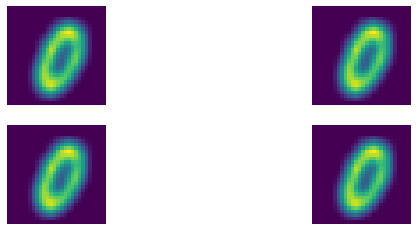

Conv layer 2 act maps: 



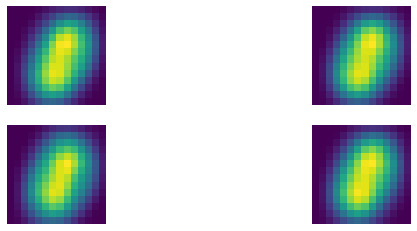

Test loss:  4.627756393675394
Test accuracy:  0.0
Conv layer1 outputs test: 


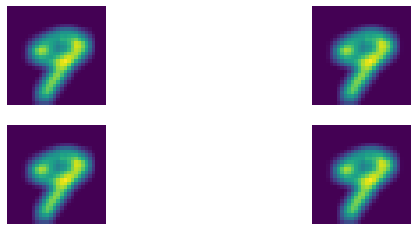

Conv layer2 outputs test: 


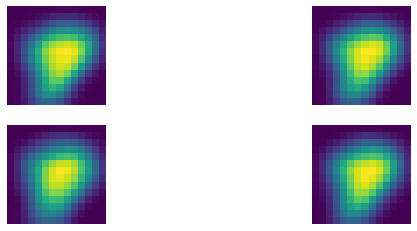

Epoch: 2/15
Train Loss:  4.122753588546066
Train accuracy 0.11
Conv layer 1 act maps: 



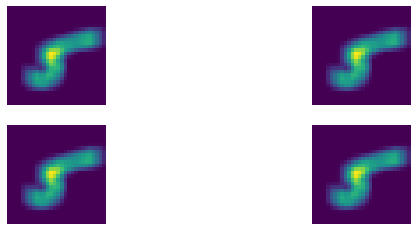

Conv layer 2 act maps: 



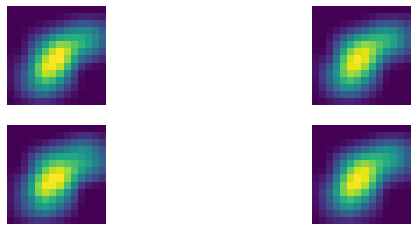

Test loss:  4.032627448889324
Test accuracy:  0.0
Conv layer1 outputs test: 


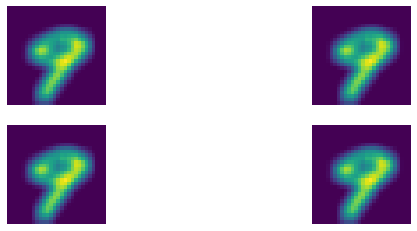

Conv layer2 outputs test: 


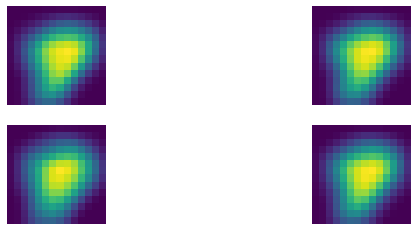

Epoch: 3/15
Train Loss:  3.722141553855623
Train accuracy 0.11300000000000003
Conv layer 1 act maps: 



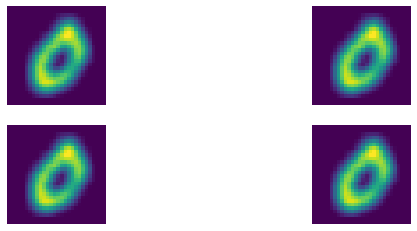

Conv layer 2 act maps: 



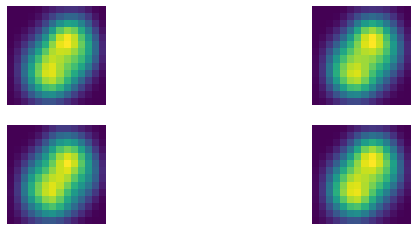

Test loss:  3.6967582988276355
Test accuracy:  0.0
Conv layer1 outputs test: 


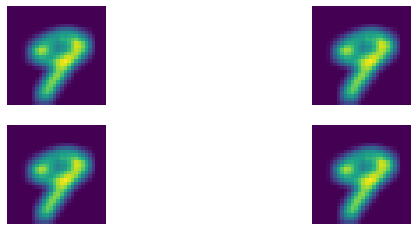

Conv layer2 outputs test: 


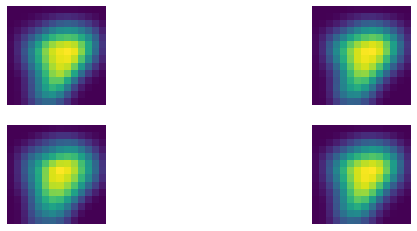

Epoch: 4/15
Train Loss:  3.4957473265337824
Train accuracy 0.149
Conv layer 1 act maps: 



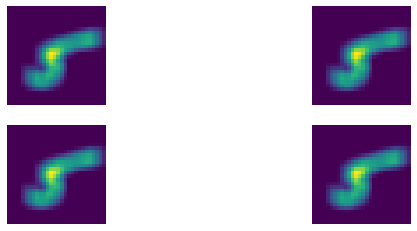

Conv layer 2 act maps: 



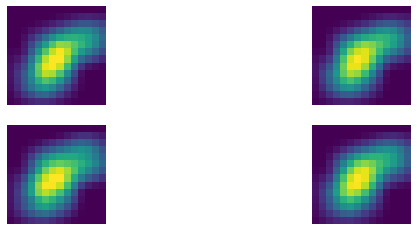

Test loss:  3.510942582080958
Test accuracy:  0.0
Conv layer1 outputs test: 


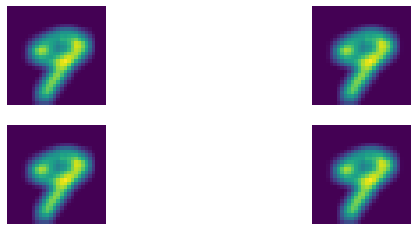

Conv layer2 outputs test: 


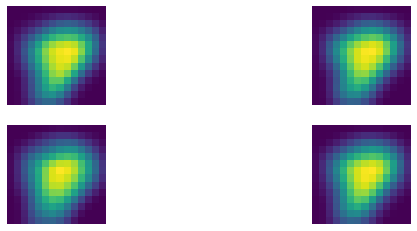

Epoch: 5/15
Train Loss:  3.364438244270971
Train accuracy 0.168
Conv layer 1 act maps: 



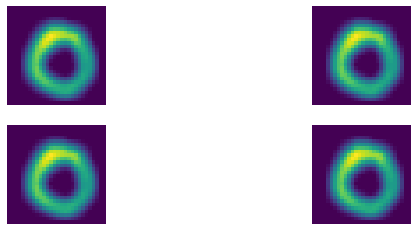

Conv layer 2 act maps: 



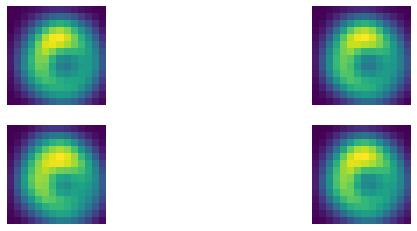

Test loss:  3.4044638657375526
Test accuracy:  0.2
Conv layer1 outputs test: 


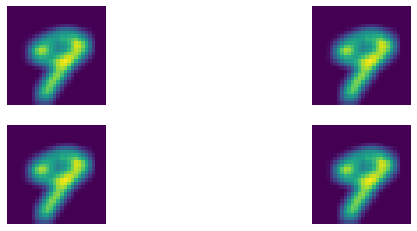

Conv layer2 outputs test: 


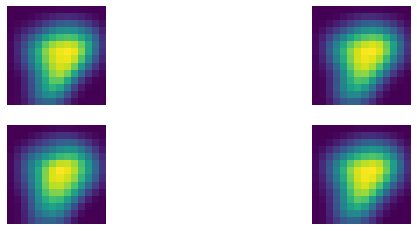

Epoch: 6/15
Train Loss:  3.290646739213812
Train accuracy 0.14
Conv layer 1 act maps: 



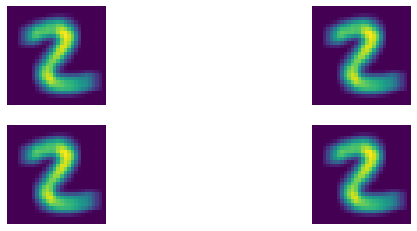

Conv layer 2 act maps: 



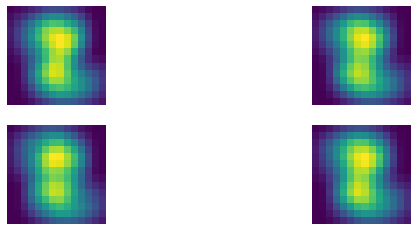

Test loss:  3.3426137387798063
Test accuracy:  0.2
Conv layer1 outputs test: 


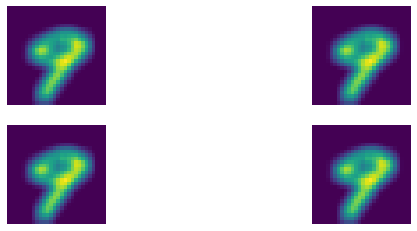

Conv layer2 outputs test: 


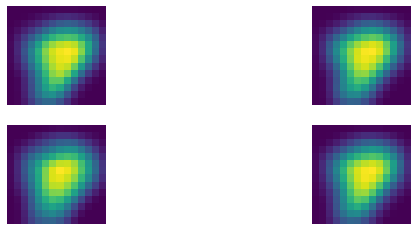

Epoch: 7/15
Train Loss:  3.251203403108627
Train accuracy 0.14
Conv layer 1 act maps: 



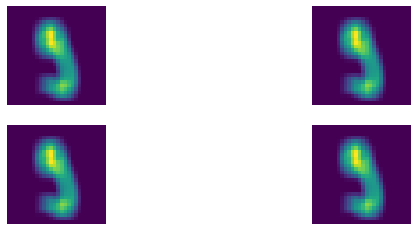

Conv layer 2 act maps: 



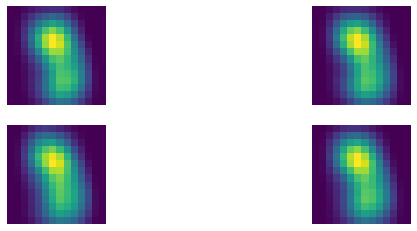

Test loss:  3.3184382891752615
Test accuracy:  0.2
Conv layer1 outputs test: 


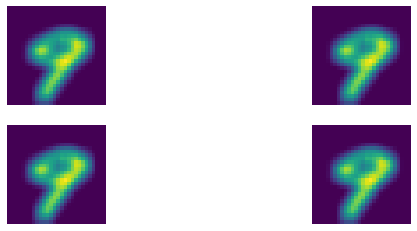

Conv layer2 outputs test: 


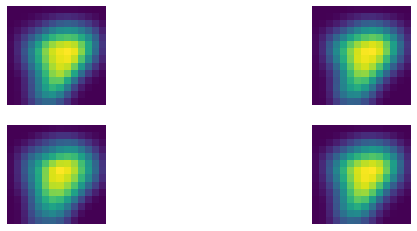

Epoch: 8/15
Train Loss:  3.2301116433189723
Train accuracy 0.13999999999999999
Conv layer 1 act maps: 



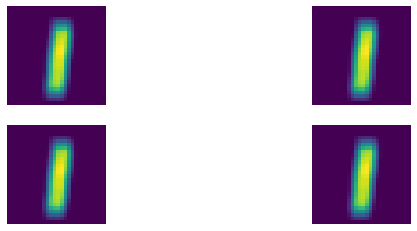

Conv layer 2 act maps: 



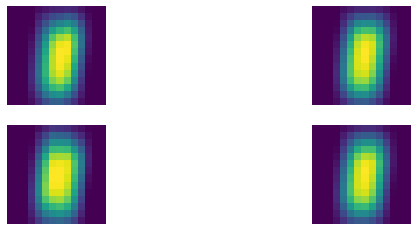

Test loss:  3.2875239435972414
Test accuracy:  0.2
Conv layer1 outputs test: 


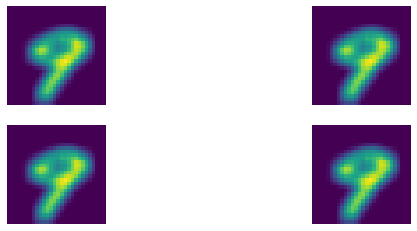

Conv layer2 outputs test: 


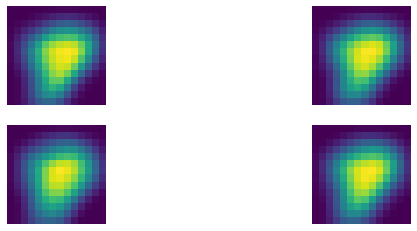

Epoch: 9/15
Train Loss:  3.218859289208705
Train accuracy 0.14
Conv layer 1 act maps: 



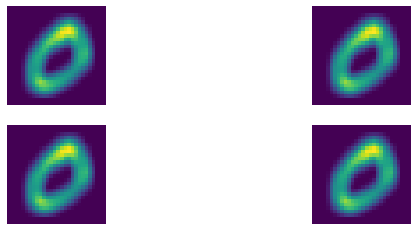

Conv layer 2 act maps: 



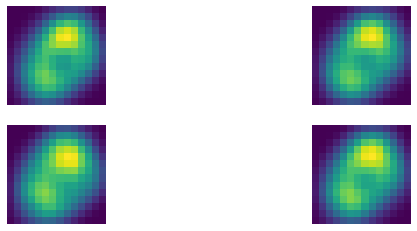

Test loss:  3.2794523211988893
Test accuracy:  0.2
Conv layer1 outputs test: 


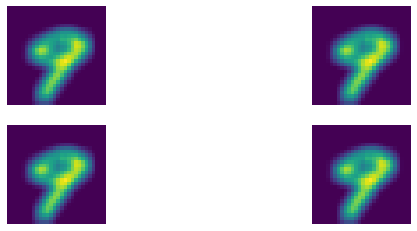

Conv layer2 outputs test: 


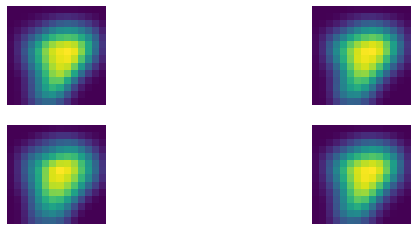

Epoch: 10/15
Train Loss:  3.2127835113278995
Train accuracy 0.14
Conv layer 1 act maps: 



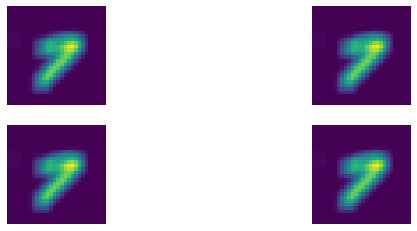

Conv layer 2 act maps: 



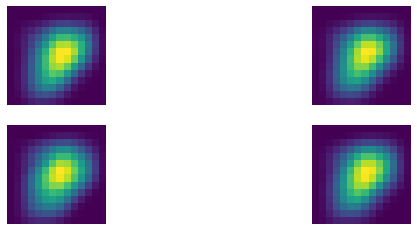

Test loss:  3.254094847235336
Test accuracy:  0.2
Conv layer1 outputs test: 


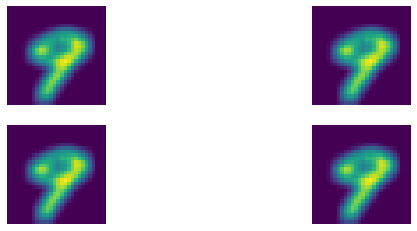

Conv layer2 outputs test: 


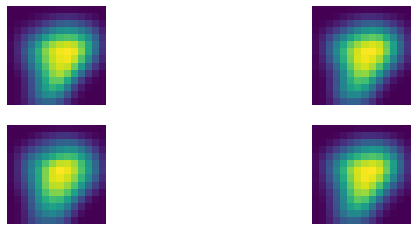

Epoch: 11/15
Train Loss:  3.2094200995199076
Train accuracy 0.14
Conv layer 1 act maps: 



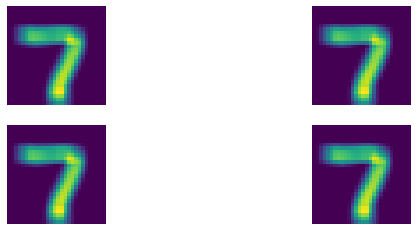

Conv layer 2 act maps: 



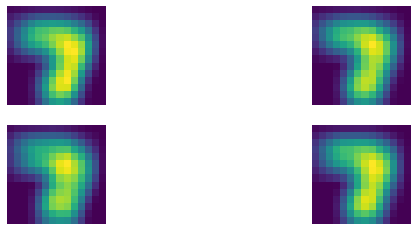

Test loss:  3.2631259337326917
Test accuracy:  0.2
Conv layer1 outputs test: 


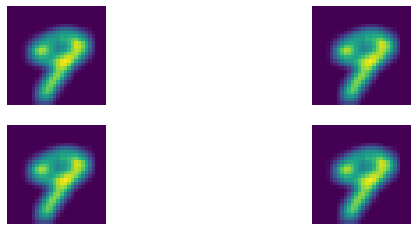

Conv layer2 outputs test: 


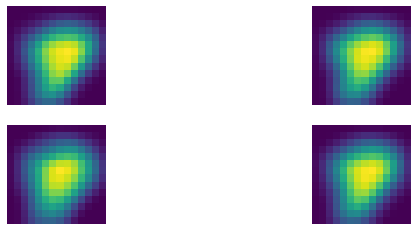

Epoch: 12/15
Train Loss:  3.20705552197575
Train accuracy 0.14
Conv layer 1 act maps: 



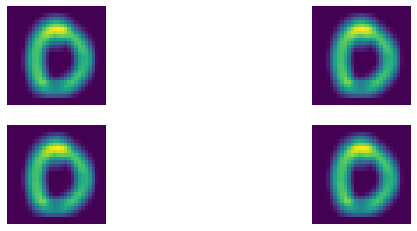

Conv layer 2 act maps: 



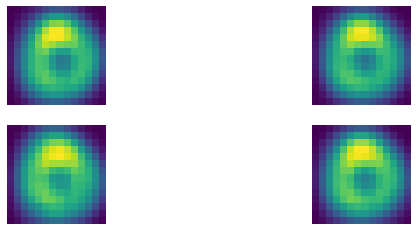

Test loss:  3.2651489870346437
Test accuracy:  0.2
Conv layer1 outputs test: 


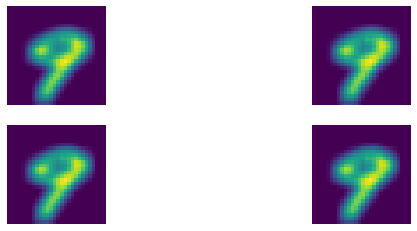

Conv layer2 outputs test: 


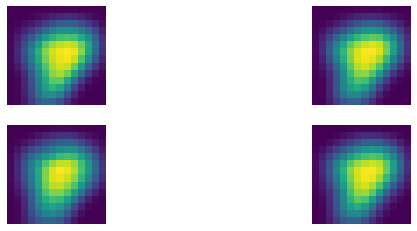

Epoch: 13/15
Train Loss:  3.2058709659845386
Train accuracy 0.14
Conv layer 1 act maps: 



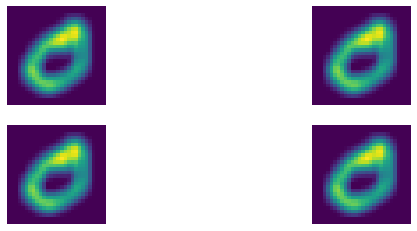

Conv layer 2 act maps: 



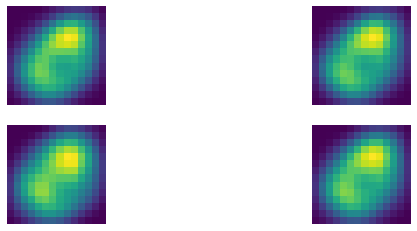

Test loss:  3.2564260068293516
Test accuracy:  0.2
Conv layer1 outputs test: 


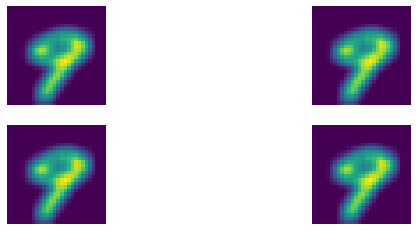

Conv layer2 outputs test: 


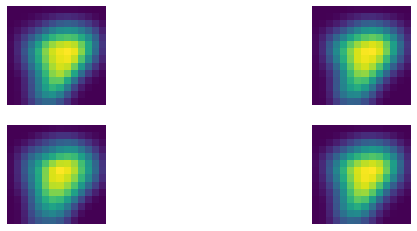

Epoch: 14/15
Train Loss:  3.2048136783559964
Train accuracy 0.14
Conv layer 1 act maps: 



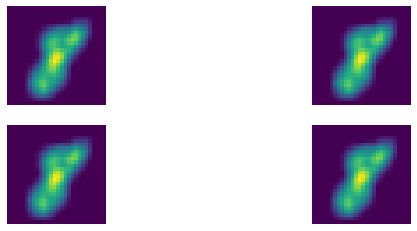

Conv layer 2 act maps: 



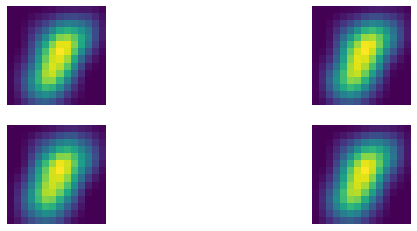

Test loss:  3.246483697224927
Test accuracy:  0.2
Conv layer1 outputs test: 


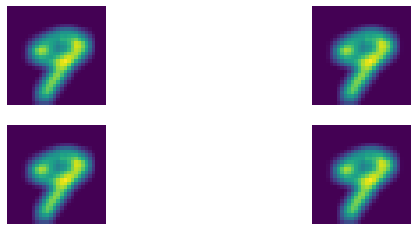

Conv layer2 outputs test: 


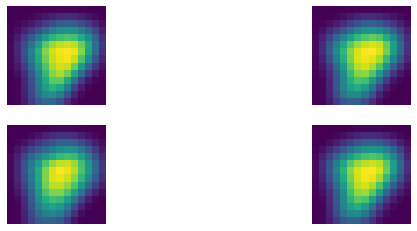

Epoch: 15/15
Train Loss:  3.2043605005687437
Train accuracy 0.13999999999999999
Conv layer 1 act maps: 



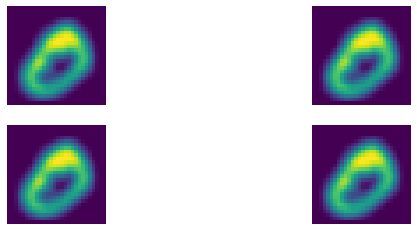

Conv layer 2 act maps: 



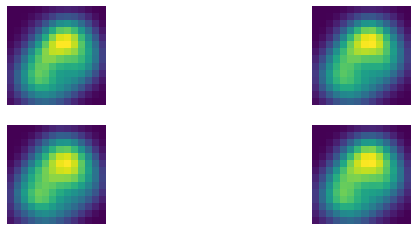

Test loss:  3.248109231917978
Test accuracy:  0.2
Conv layer1 outputs test: 


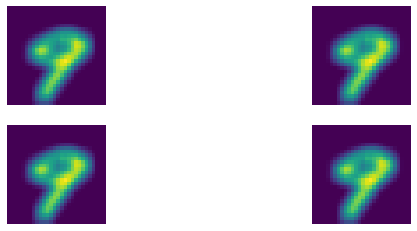

Conv layer2 outputs test: 


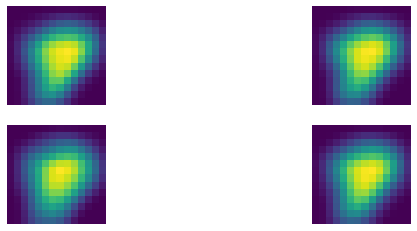


 Train loss vs Test loss


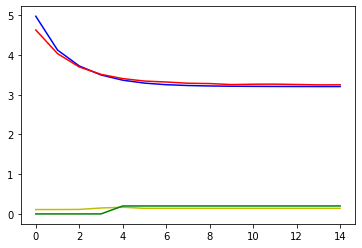

C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


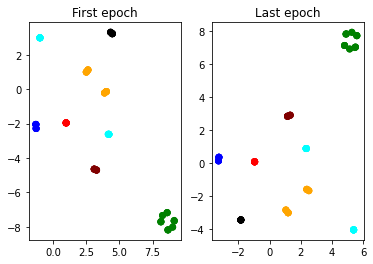

In [140]:
#SGD Batch size 20
avg_losses_epochs1,accuracies1,test_losses1,test_accuracies1,bottleneck_outputs1 = convnet.train(train_data,test_data,20,15,'sgd',tsne=True)

In [195]:
convnet = ConvNet(196,1,[49],10)

Epoch: 1/3
Train Loss:  3.9743106486812323
Train accuracy 0.10800000000000001
Conv layer 1 act maps: 



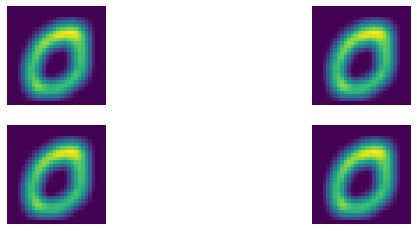

Conv layer 2 act maps: 



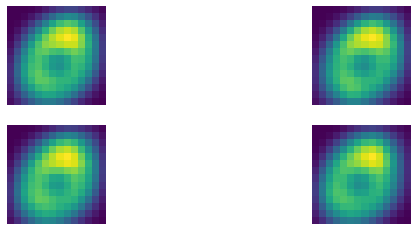

Test loss:  3.755228843939006
Test accuracy:  0.2
Conv layer1 outputs test: 


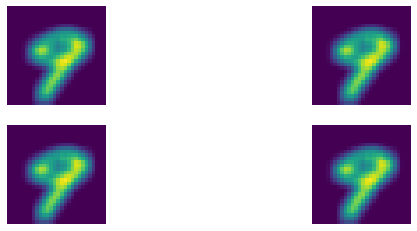

Conv layer2 outputs test: 


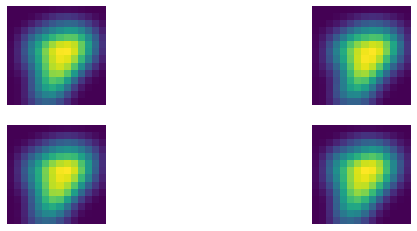

Epoch: 2/3
Train Loss:  3.8755690738968434
Train accuracy 0.08100000000000003
Conv layer 1 act maps: 



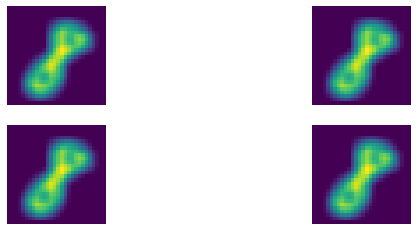

Conv layer 2 act maps: 



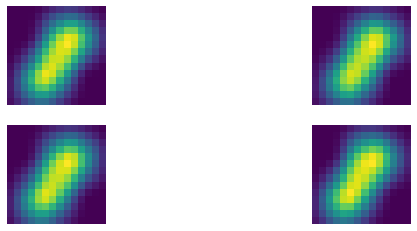

Test loss:  3.686151894264052
Test accuracy:  0.2
Conv layer1 outputs test: 


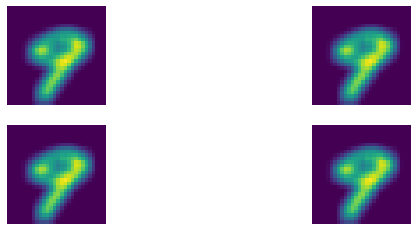

Conv layer2 outputs test: 


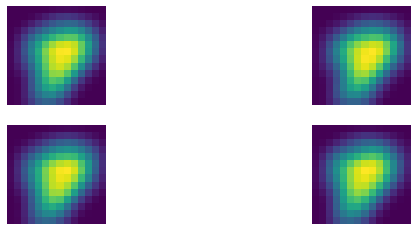

Epoch: 3/3
Train Loss:  3.7891563206939978
Train accuracy 0.13300000000000003
Conv layer 1 act maps: 



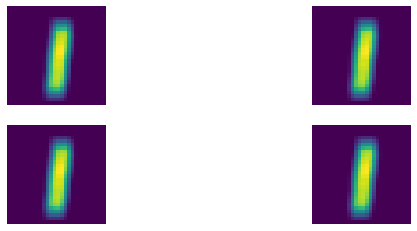

Conv layer 2 act maps: 



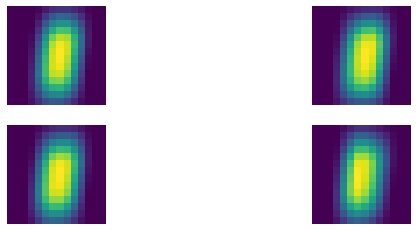

Test loss:  3.6264123771933123
Test accuracy:  0.2
Conv layer1 outputs test: 


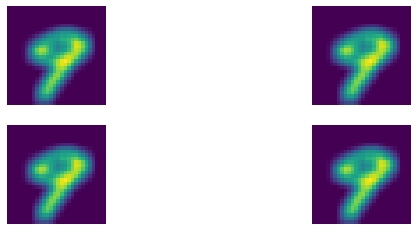

Conv layer2 outputs test: 


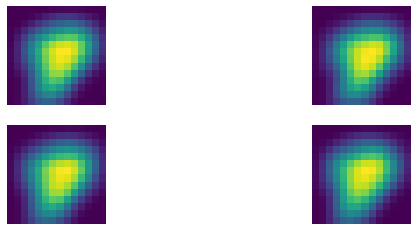


 Train loss vs Test loss


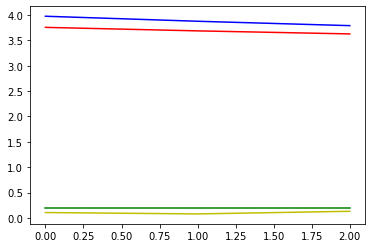

In [196]:
#SGD Batch size-50
avg_losses_epochs2,accuracies2,test_losses2,test_accuracies2,bottleneck_outputs2 = convnet.train(train_data,test_data,50,3,'sgd')

In [193]:
convnet2 = ConvNet(196,1,[49],10)

Epoch: 1/15
Train Loss:  4.154536917243404
Train accuracy 0.11599999999999999
Conv layer 1 act maps: 



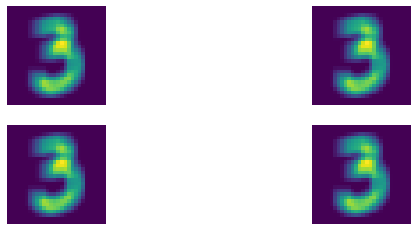

Conv layer 2 act maps: 



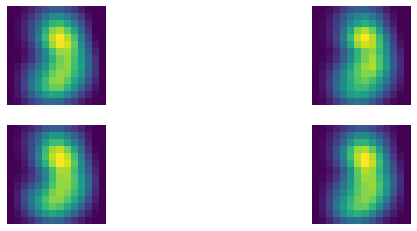

Test loss:  3.221662282784215
Test accuracy:  0.2
Conv layer1 outputs test: 


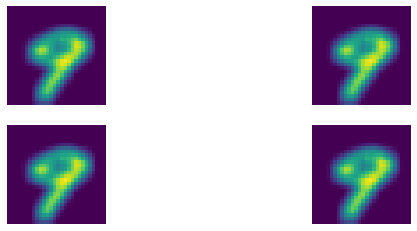

Conv layer2 outputs test: 


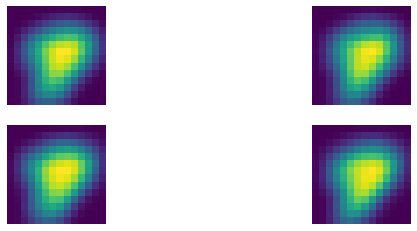

Epoch: 2/15
Train Loss:  3.2274465494607574
Train accuracy 0.12
Conv layer 1 act maps: 



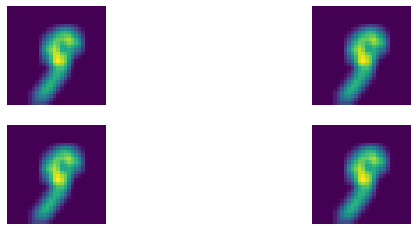

Conv layer 2 act maps: 



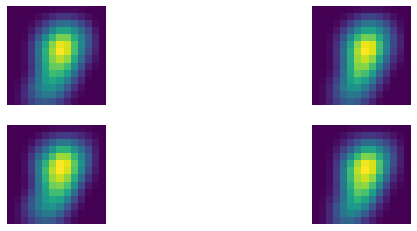

Test loss:  3.2103318297107197
Test accuracy:  0.2
Conv layer1 outputs test: 


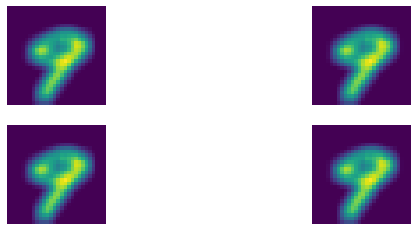

Conv layer2 outputs test: 


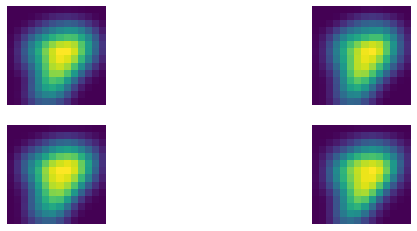

Epoch: 3/15
Train Loss:  3.2224134391910075
Train accuracy 0.133
Conv layer 1 act maps: 



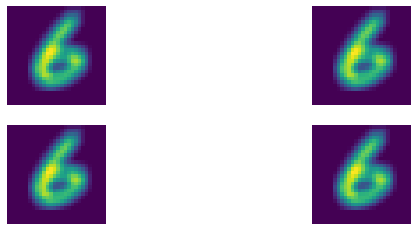

Conv layer 2 act maps: 



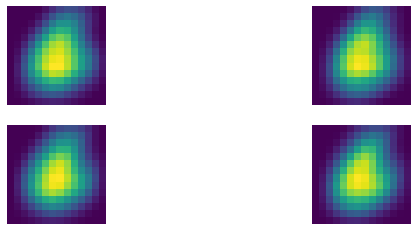

Test loss:  3.244435744265035
Test accuracy:  0.1
Conv layer1 outputs test: 


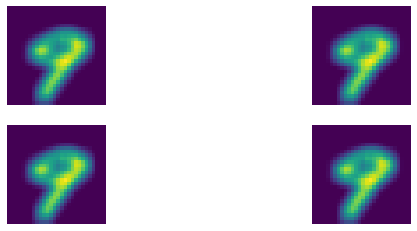

Conv layer2 outputs test: 


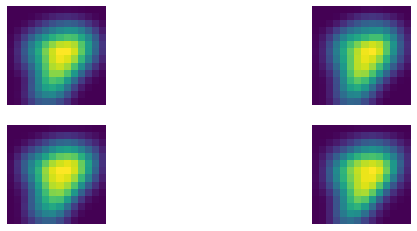

Epoch: 4/15
Train Loss:  3.2207555356850133
Train accuracy 0.135
Conv layer 1 act maps: 



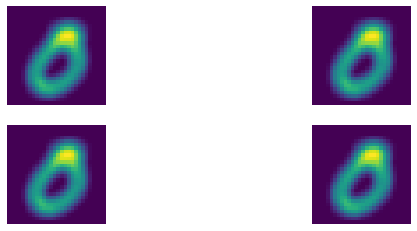

Conv layer 2 act maps: 



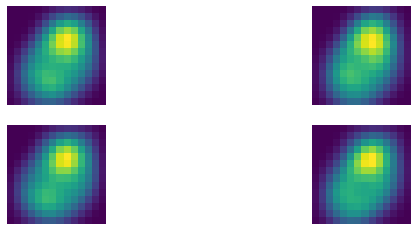

Test loss:  3.2434340153522703
Test accuracy:  0.2
Conv layer1 outputs test: 


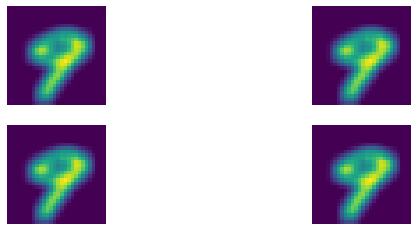

Conv layer2 outputs test: 


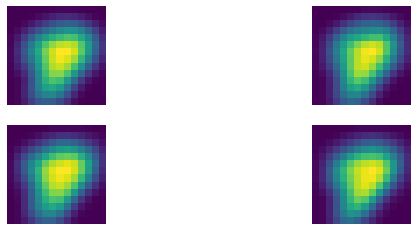

Epoch: 5/15
Train Loss:  3.220793852880344
Train accuracy 0.146
Conv layer 1 act maps: 



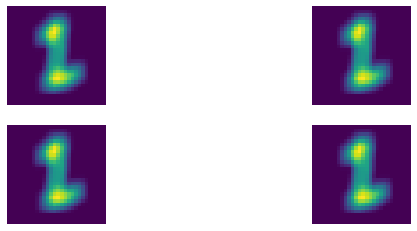

Conv layer 2 act maps: 



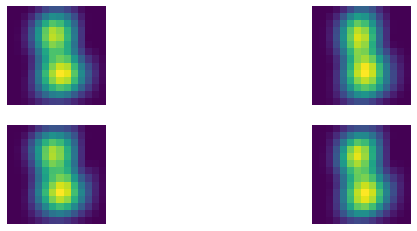

Test loss:  3.211814675419738
Test accuracy:  0.1
Conv layer1 outputs test: 


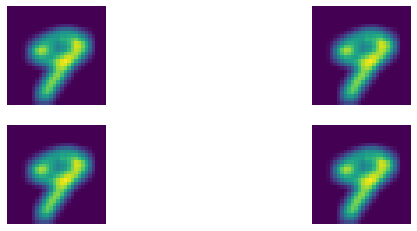

Conv layer2 outputs test: 


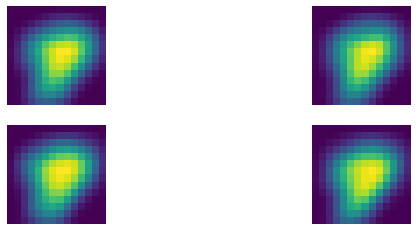

Epoch: 6/15
Train Loss:  3.224064853931285
Train accuracy 0.142
Conv layer 1 act maps: 



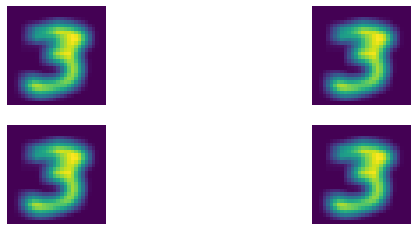

Conv layer 2 act maps: 



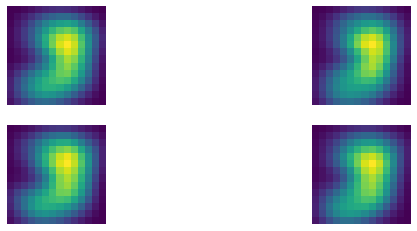

Test loss:  3.2064554684119972
Test accuracy:  0.2
Conv layer1 outputs test: 


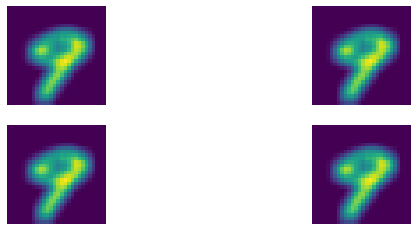

Conv layer2 outputs test: 


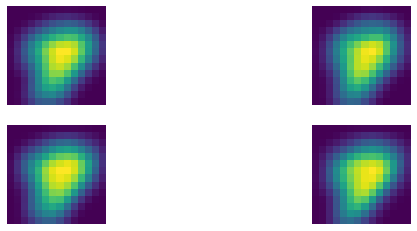

Epoch: 7/15
Train Loss:  3.224007446916644
Train accuracy 0.126
Conv layer 1 act maps: 



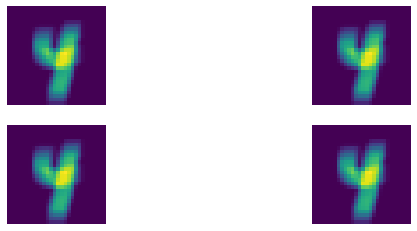

Conv layer 2 act maps: 



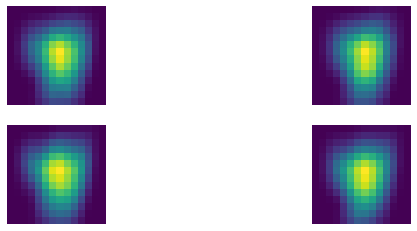

Test loss:  3.203534935934672
Test accuracy:  0.2
Conv layer1 outputs test: 


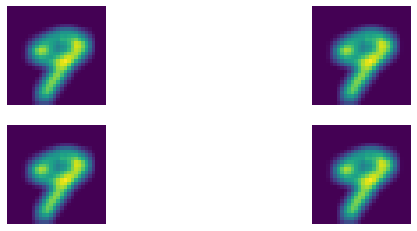

Conv layer2 outputs test: 


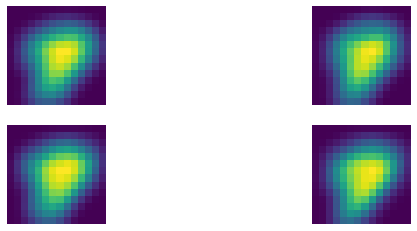

Epoch: 8/15
Train Loss:  3.2211614738780296
Train accuracy 0.12299999999999998
Conv layer 1 act maps: 



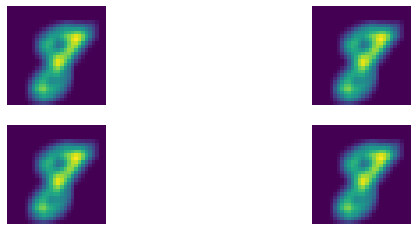

Conv layer 2 act maps: 



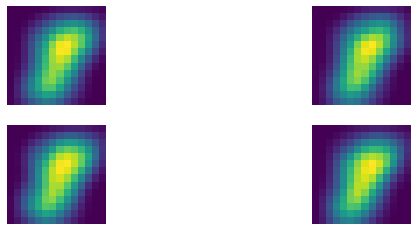

Test loss:  3.241202578333361
Test accuracy:  0.2
Conv layer1 outputs test: 


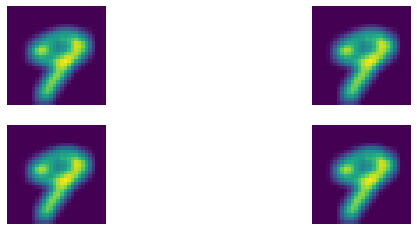

Conv layer2 outputs test: 


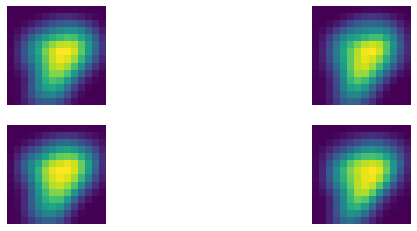

Epoch: 9/15
Train Loss:  3.2192490237975995
Train accuracy 0.12000000000000002
Conv layer 1 act maps: 



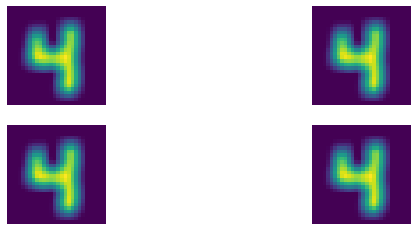

Conv layer 2 act maps: 



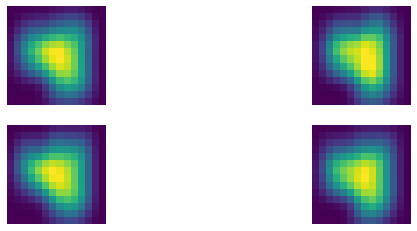

Test loss:  3.24551404884121
Test accuracy:  0.2
Conv layer1 outputs test: 


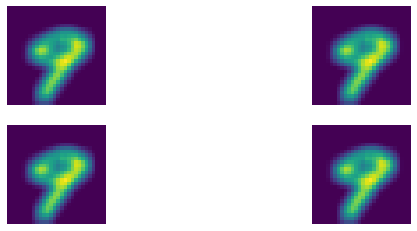

Conv layer2 outputs test: 


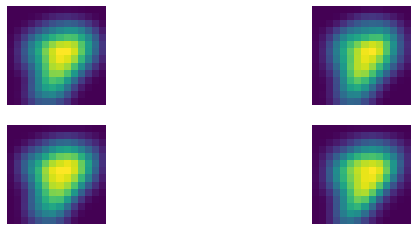

Epoch: 10/15
Train Loss:  3.2179697187683614
Train accuracy 0.135
Conv layer 1 act maps: 



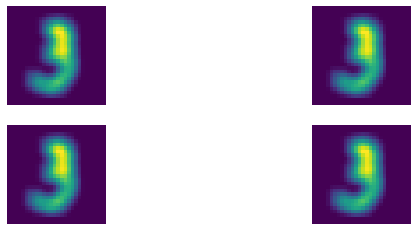

Conv layer 2 act maps: 



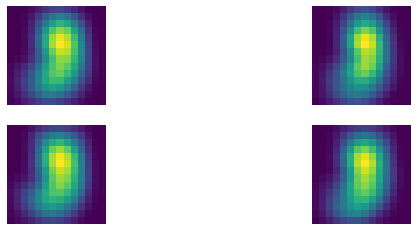

Test loss:  3.231415815261479
Test accuracy:  0.2
Conv layer1 outputs test: 


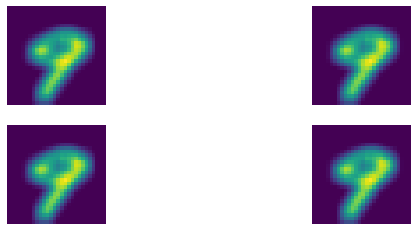

Conv layer2 outputs test: 


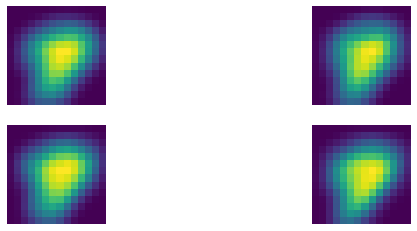

Epoch: 11/15
Train Loss:  3.2227283882142443
Train accuracy 0.14
Conv layer 1 act maps: 



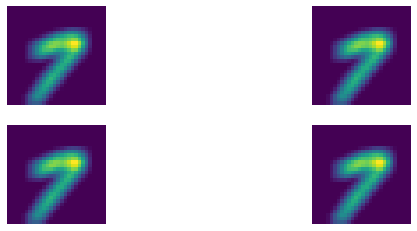

Conv layer 2 act maps: 



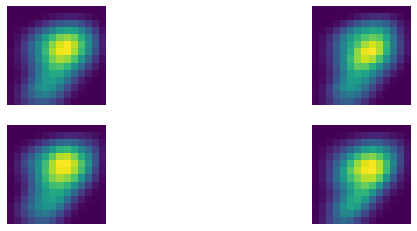

Test loss:  3.2491605629255997
Test accuracy:  0.2
Conv layer1 outputs test: 


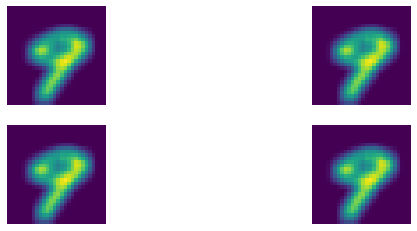

Conv layer2 outputs test: 


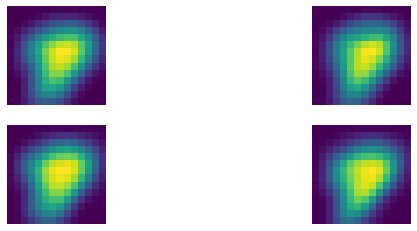

Epoch: 12/15
Train Loss:  3.2198630016656278
Train accuracy 0.139
Conv layer 1 act maps: 



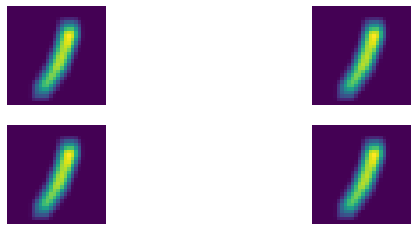

Conv layer 2 act maps: 



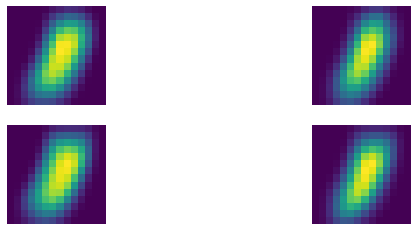

Test loss:  3.2236173301295
Test accuracy:  0.1
Conv layer1 outputs test: 


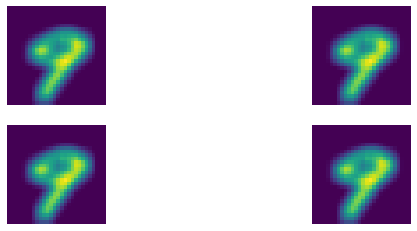

Conv layer2 outputs test: 


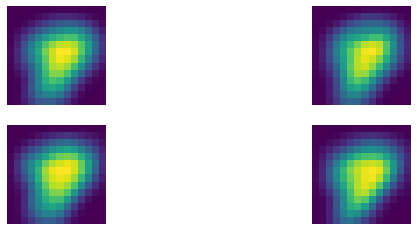

Epoch: 13/15
Train Loss:  3.2230361786421935
Train accuracy 0.10499999999999998
Conv layer 1 act maps: 



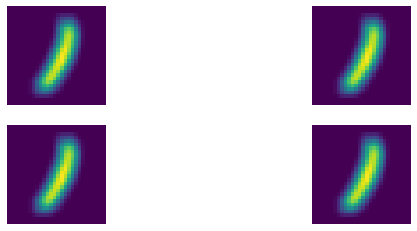

Conv layer 2 act maps: 



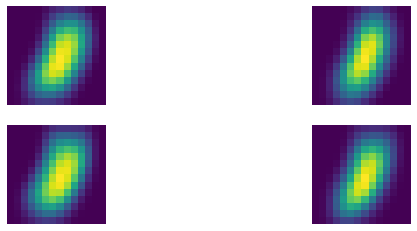

Test loss:  3.217894663720601
Test accuracy:  0.2
Conv layer1 outputs test: 


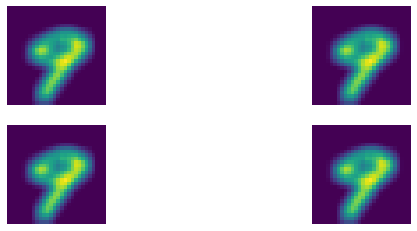

Conv layer2 outputs test: 


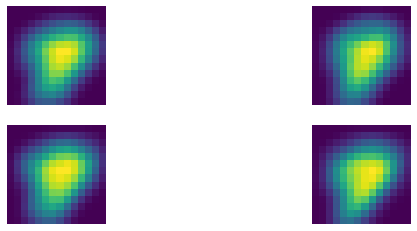

Epoch: 14/15
Train Loss:  3.2195943978321013
Train accuracy 0.14100000000000004
Conv layer 1 act maps: 



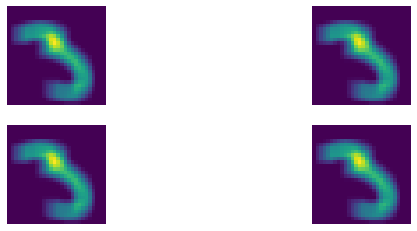

Conv layer 2 act maps: 



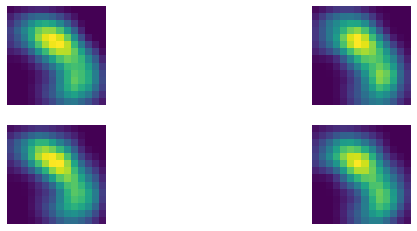

Test loss:  3.251203402562038
Test accuracy:  0.1
Conv layer1 outputs test: 


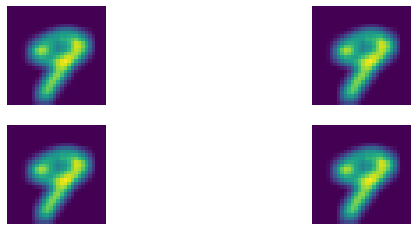

Conv layer2 outputs test: 


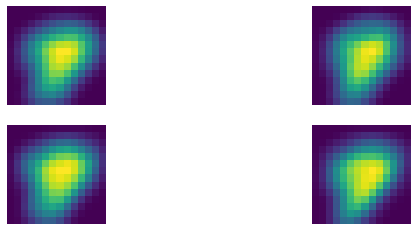

Epoch: 15/15
Train Loss:  3.2170211594296445
Train accuracy 0.134
Conv layer 1 act maps: 



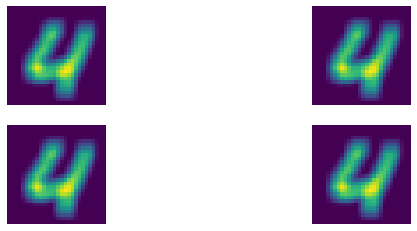

Conv layer 2 act maps: 



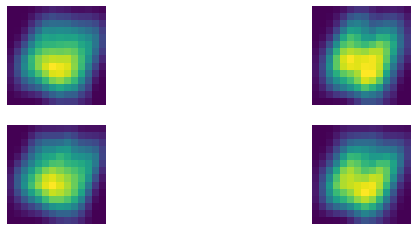

Test loss:  3.233070112828941
Test accuracy:  0.2
Conv layer1 outputs test: 


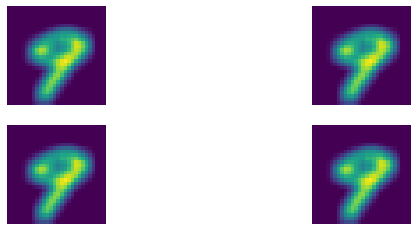

Conv layer2 outputs test: 


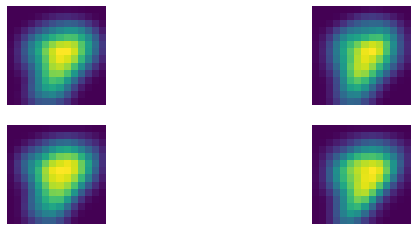


 Train loss vs Test loss


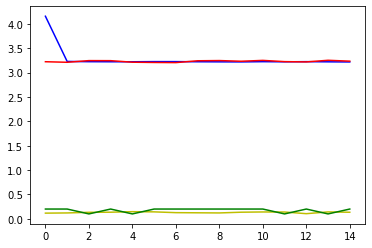

C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


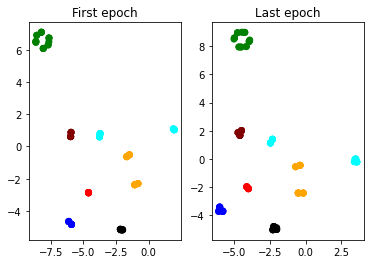

In [194]:
#Momentum Batch size-20
avg_losses_epochs3,accuracies3,test_losses3,test_accuracies3,bottleneck_outputs3 = convnet2.train(train_data,test_data,20,15,'momentum',tsne=True)

In [197]:
convnet = ConvNet(196,1,[49],10)

Epoch: 1/3
Train Loss:  5.3078188261472885
Train accuracy 0.14100000000000001
Conv layer 1 act maps: 



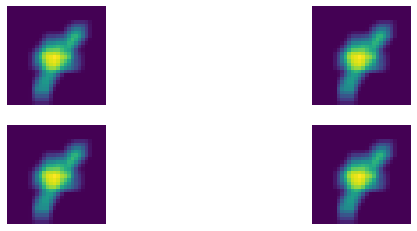

Conv layer 2 act maps: 



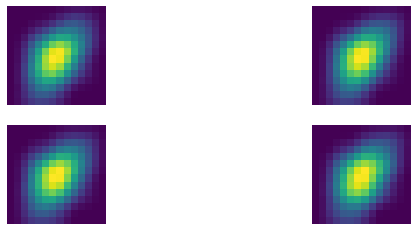

Test loss:  3.757254184440175
Test accuracy:  0.1
Conv layer1 outputs test: 


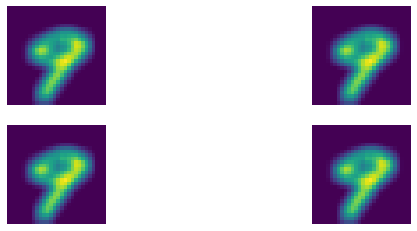

Conv layer2 outputs test: 


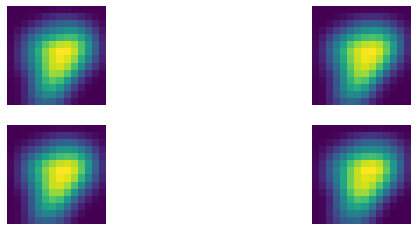

Epoch: 2/3
Train Loss:  3.720675259210205
Train accuracy 0.11300000000000002
Conv layer 1 act maps: 



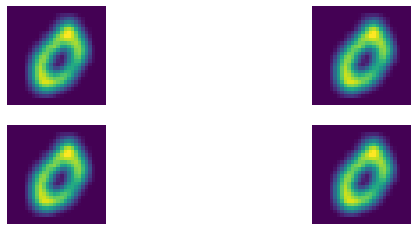

Conv layer 2 act maps: 



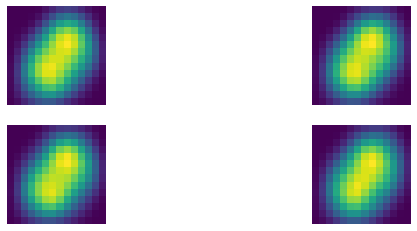

Test loss:  3.3496834086338705
Test accuracy:  0.0
Conv layer1 outputs test: 


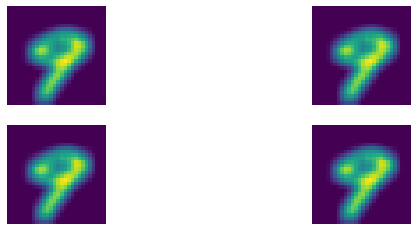

Conv layer2 outputs test: 


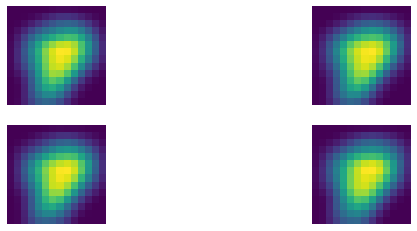

Epoch: 3/3
Train Loss:  3.290689824414816
Train accuracy 0.101
Conv layer 1 act maps: 



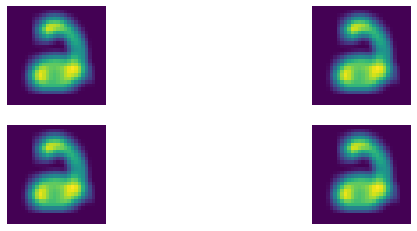

Conv layer 2 act maps: 



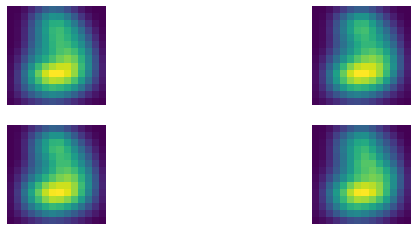

Test loss:  3.222403580404075
Test accuracy:  0.2
Conv layer1 outputs test: 


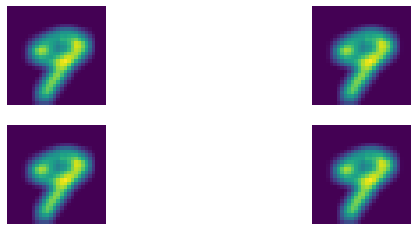

Conv layer2 outputs test: 


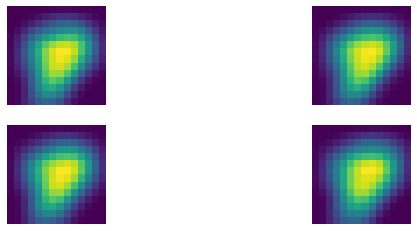


 Train loss vs Test loss


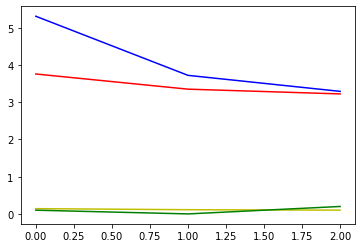

In [198]:
#Momentum Batch size-50
avg_losses_epochs4,accuracies4,test_losses4,test_accuracies4,bottleneck_outputs4 = convnet.train(train_data,test_data,50,3,'momentum')

In [188]:
convnet1 = ConvNet(196,1,[49],10)

Epoch: 1/15
Train Loss:  5.668529790173264
Train accuracy 0.05
Conv layer 1 act maps: 



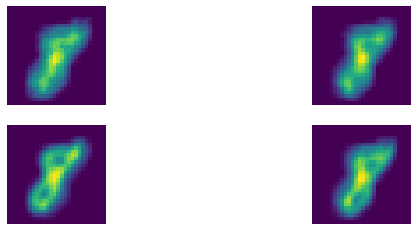

Conv layer 2 act maps: 



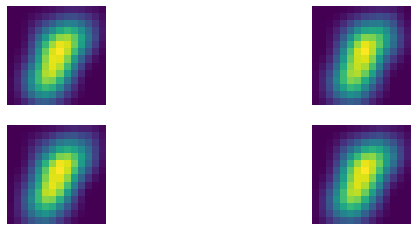

Test loss:  6.0418965613930675
Test accuracy:  0.1
Conv layer1 outputs test: 


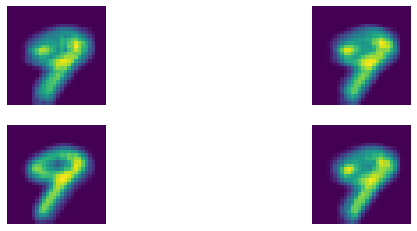

Conv layer2 outputs test: 


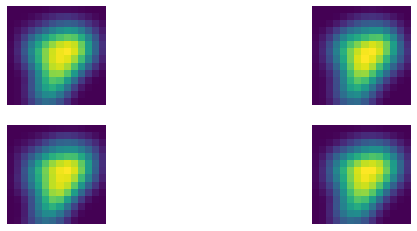

Epoch: 2/15
Train Loss:  5.234273520944692
Train accuracy 0.05
Conv layer 1 act maps: 



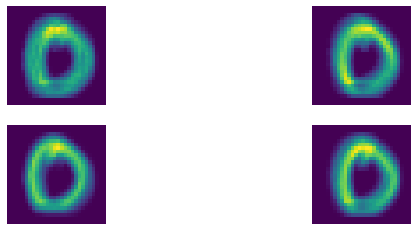

Conv layer 2 act maps: 



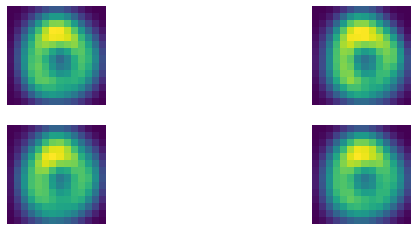

Test loss:  5.598887283703633
Test accuracy:  0.1
Conv layer1 outputs test: 


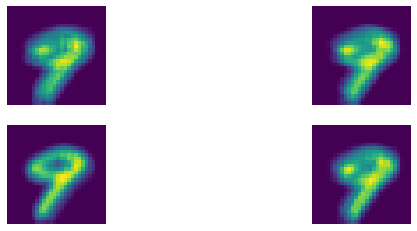

Conv layer2 outputs test: 


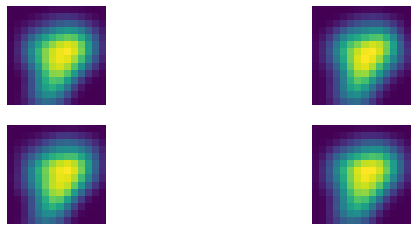

Epoch: 3/15
Train Loss:  4.8773242130472925
Train accuracy 0.05
Conv layer 1 act maps: 



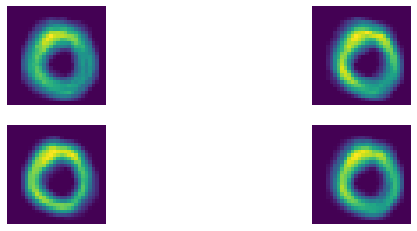

Conv layer 2 act maps: 



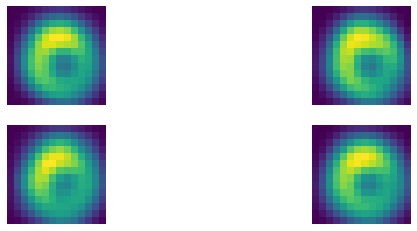

Test loss:  5.2026241276613385
Test accuracy:  0.1
Conv layer1 outputs test: 


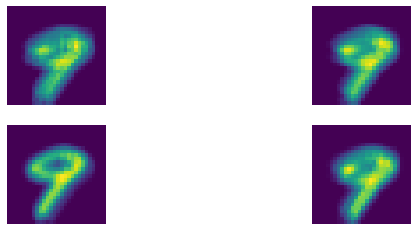

Conv layer2 outputs test: 


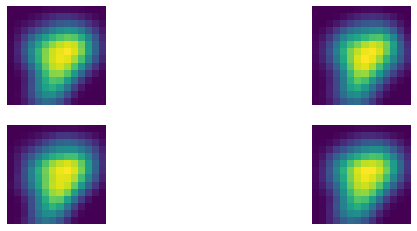

Epoch: 4/15
Train Loss:  4.554995732459637
Train accuracy 0.05
Conv layer 1 act maps: 



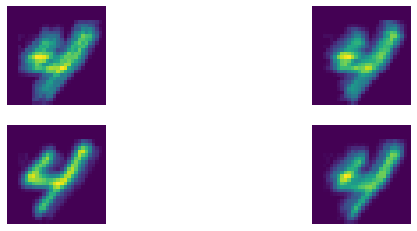

Conv layer 2 act maps: 



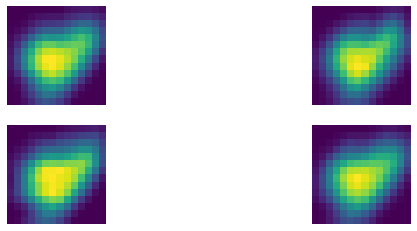

Test loss:  4.839577396302099
Test accuracy:  0.1
Conv layer1 outputs test: 


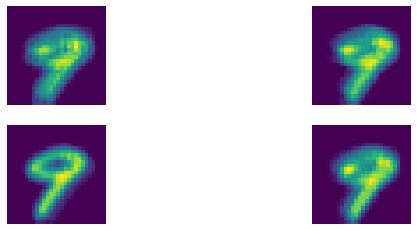

Conv layer2 outputs test: 


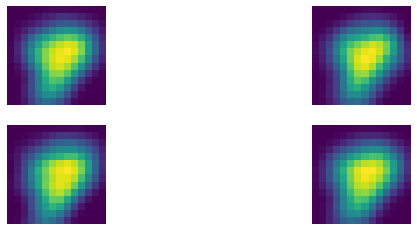

Epoch: 5/15
Train Loss:  4.2991444393863
Train accuracy 0.05
Conv layer 1 act maps: 



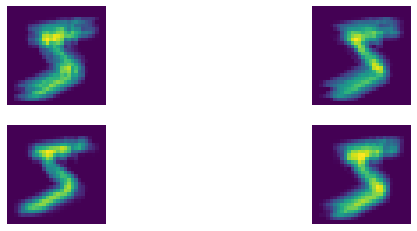

Conv layer 2 act maps: 



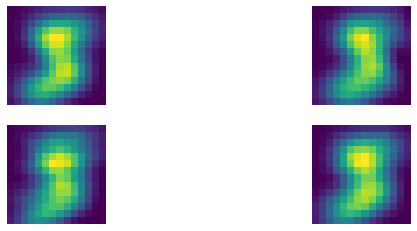

Test loss:  4.549894420784299
Test accuracy:  0.1
Conv layer1 outputs test: 


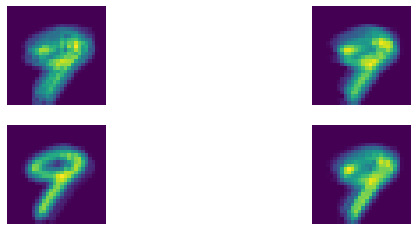

Conv layer2 outputs test: 


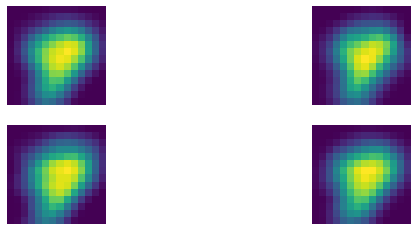

Epoch: 6/15
Train Loss:  4.068304375129139
Train accuracy 0.05
Conv layer 1 act maps: 



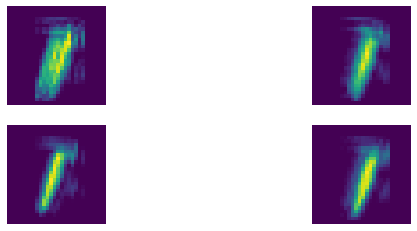

Conv layer 2 act maps: 



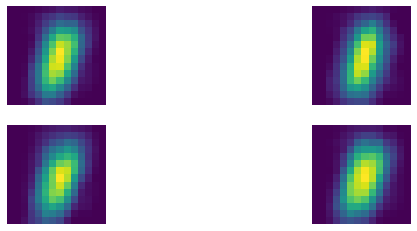

Test loss:  4.287728397233322
Test accuracy:  0.1
Conv layer1 outputs test: 


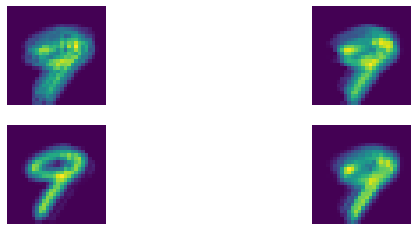

Conv layer2 outputs test: 


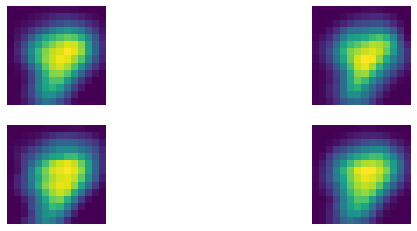

Epoch: 7/15
Train Loss:  3.8746490670654476
Train accuracy 0.083
Conv layer 1 act maps: 



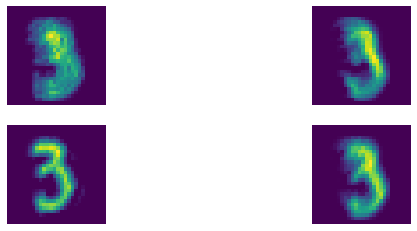

Conv layer 2 act maps: 



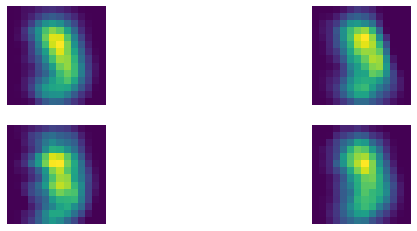

Test loss:  4.055678640471053
Test accuracy:  0.2
Conv layer1 outputs test: 


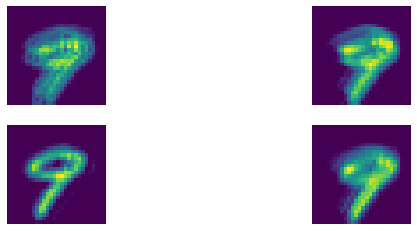

Conv layer2 outputs test: 


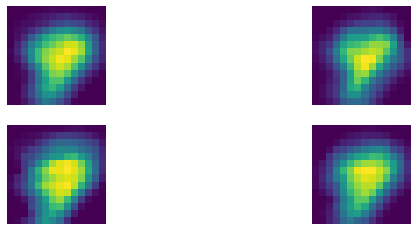

Epoch: 8/15
Train Loss:  3.7061803652698377
Train accuracy 0.157
Conv layer 1 act maps: 



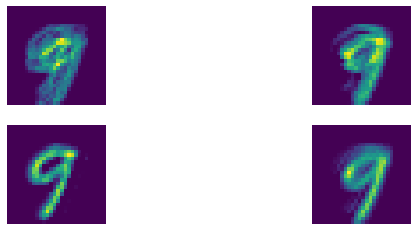

Conv layer 2 act maps: 



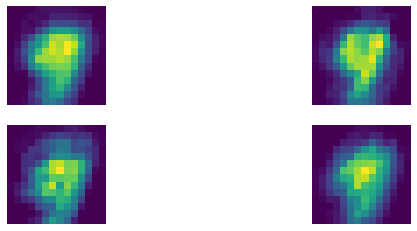

Test loss:  3.856840296829523
Test accuracy:  0.2
Conv layer1 outputs test: 


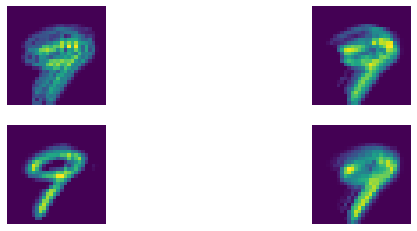

Conv layer2 outputs test: 


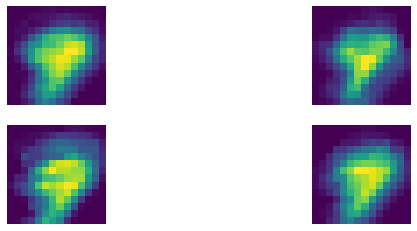

Epoch: 9/15
Train Loss:  3.5692561263189244
Train accuracy 0.161
Conv layer 1 act maps: 



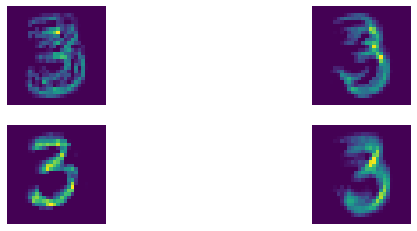

Conv layer 2 act maps: 



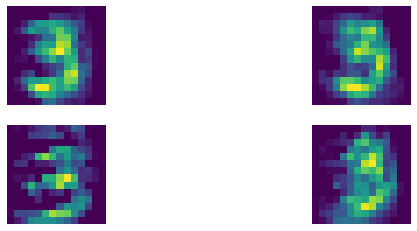

Test loss:  3.713546713756523
Test accuracy:  0.1
Conv layer1 outputs test: 


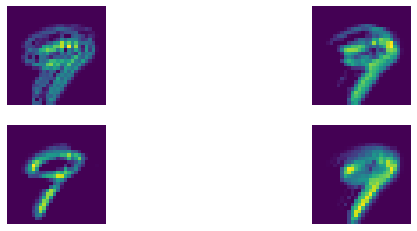

Conv layer2 outputs test: 


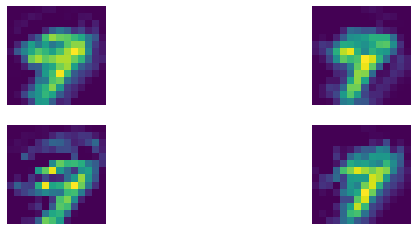

Epoch: 10/15
Train Loss:  3.609356779625321
Train accuracy 0.09
Conv layer 1 act maps: 



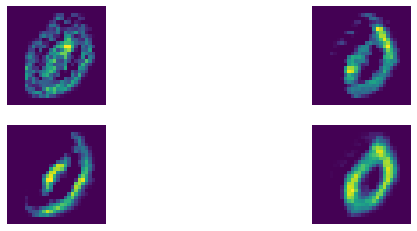

Conv layer 2 act maps: 



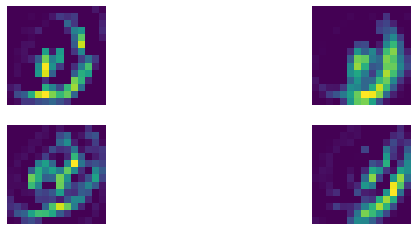

Test loss:  3.551640879632326
Test accuracy:  0.1
Conv layer1 outputs test: 


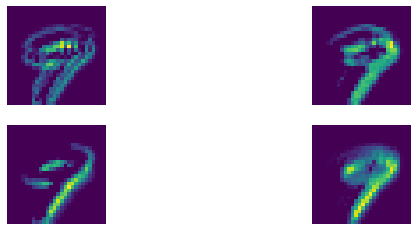

Conv layer2 outputs test: 


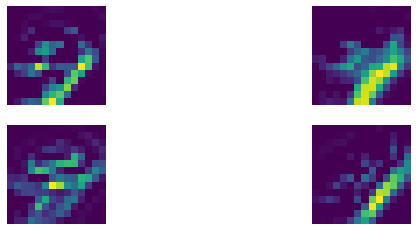

Epoch: 11/15
Train Loss:  3.6561587023971627
Train accuracy 0.11100000000000002
Conv layer 1 act maps: 



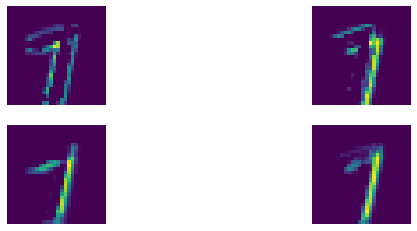

Conv layer 2 act maps: 



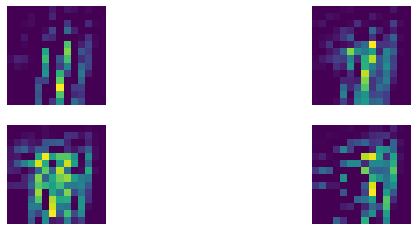

Test loss:  3.3144704896044743
Test accuracy:  0.0
Conv layer1 outputs test: 


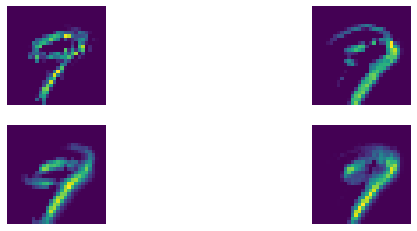

Conv layer2 outputs test: 


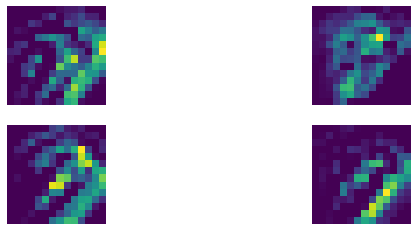

Epoch: 12/15
Train Loss:  3.2617369118291877
Train accuracy 0.07200000000000001
Conv layer 1 act maps: 



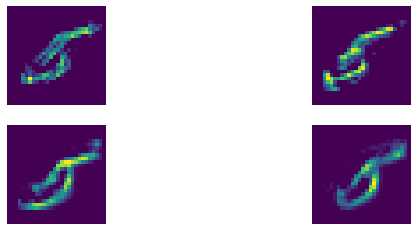

Conv layer 2 act maps: 



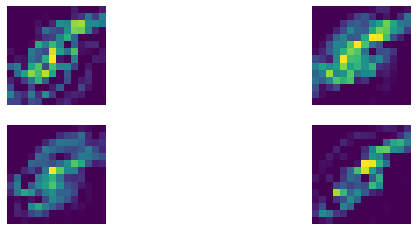

Test loss:  3.2401679346071277
Test accuracy:  0.2
Conv layer1 outputs test: 


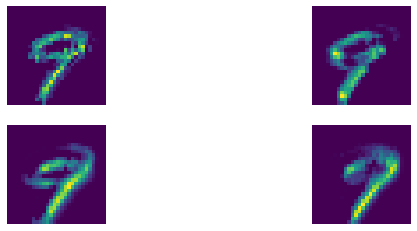

Conv layer2 outputs test: 


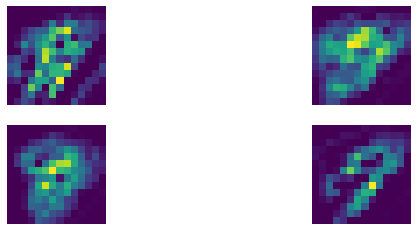

Epoch: 13/15
Train Loss:  3.2520805750169655
Train accuracy 0.07600000000000001
Conv layer 1 act maps: 



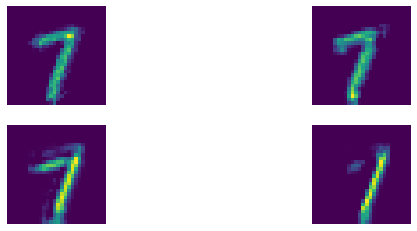

Conv layer 2 act maps: 



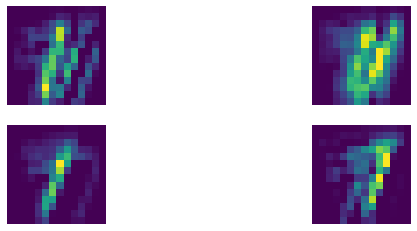

Test loss:  3.25348119713378
Test accuracy:  0.1
Conv layer1 outputs test: 


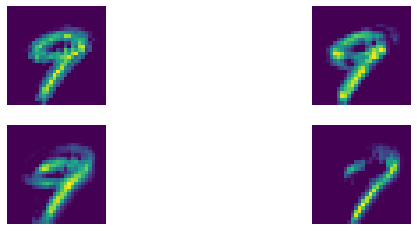

Conv layer2 outputs test: 


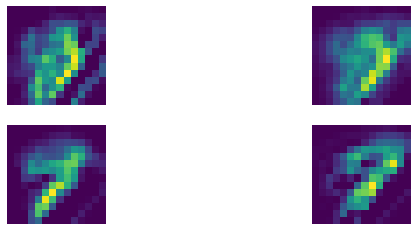

Epoch: 14/15
Train Loss:  3.2534170350045684
Train accuracy 0.14400000000000002
Conv layer 1 act maps: 



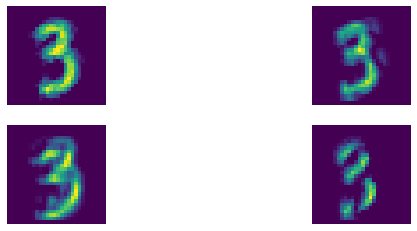

Conv layer 2 act maps: 



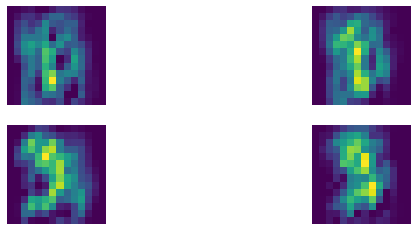

Test loss:  3.2569413674282037
Test accuracy:  0.1
Conv layer1 outputs test: 


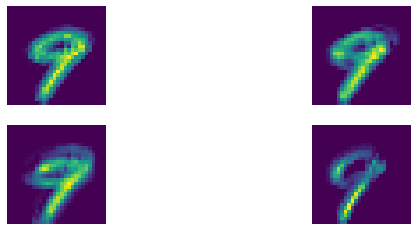

Conv layer2 outputs test: 


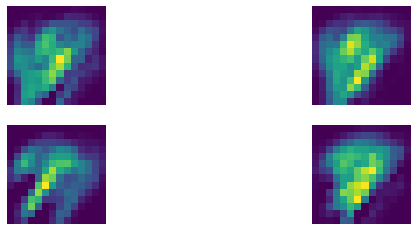

Epoch: 15/15
Train Loss:  3.2529481595818255
Train accuracy 0.099
Conv layer 1 act maps: 



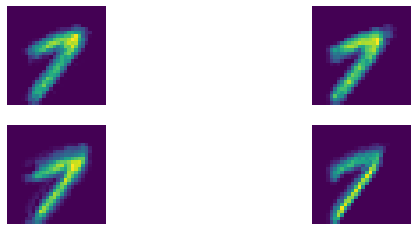

Conv layer 2 act maps: 



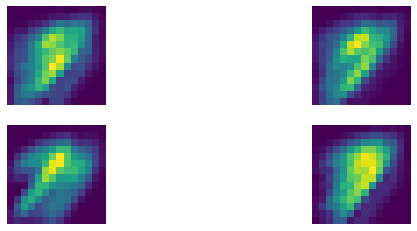

Test loss:  3.270596609666603
Test accuracy:  0.0
Conv layer1 outputs test: 


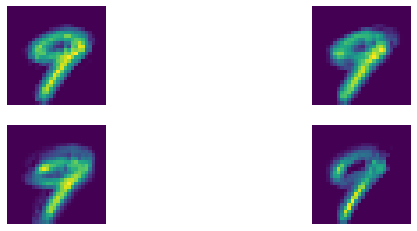

Conv layer2 outputs test: 


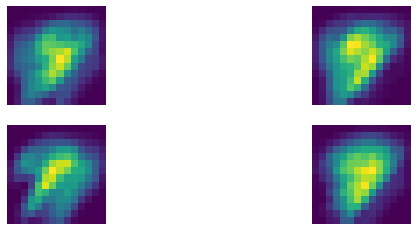


 Train loss vs Test loss


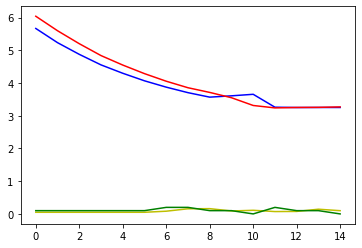

C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\aksha\python-virtualenv\yolov5\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


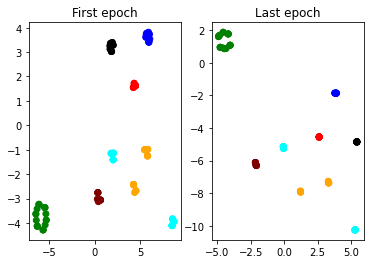

In [189]:
#Rmsprop Batch size-20
avg_losses_epochs5,accuracies5,test_losses5,test_accuracies5,bottleneck_outputs5 = convnet1.train(train_data,test_data,20,15,'rmsprop',tsne=True)